In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
gas=np.load('/Users/yomori/Grids_Mgas_IllustrisTNG_CV_128_z=0.0.npy')
cdm=np.load('/Users/yomori/Grids_Mcdm_IllustrisTNG_CV_128_z=0.0.npy')
tot=np.load('/Users/yomori/Grids_Mtot_IllustrisTNG_CV_128_z=0.0.npy')


<Figure size 640x480 with 0 Axes>

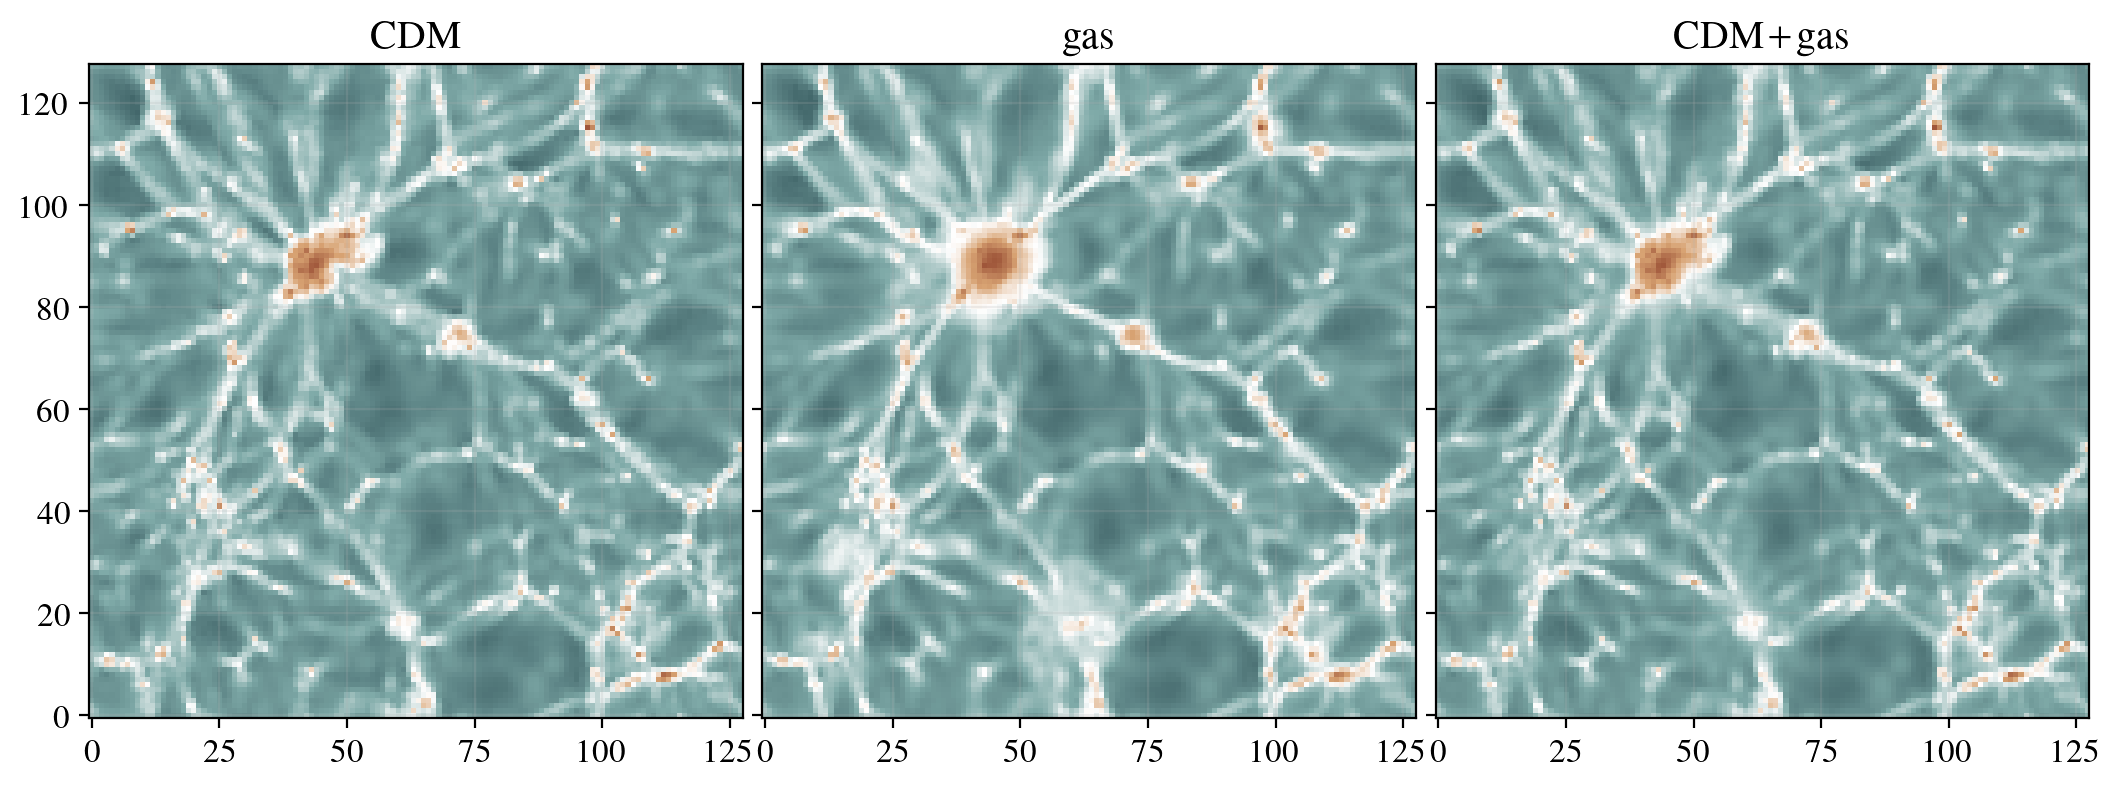

In [2]:
import suisai
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

plt.clf()
fig = plt.figure(figsize=(10,5))
gs  = gridspec.GridSpec(1, 3,
                       top=0.95,
                       right=1.00,
                       left=0.00,
                       bottom=0.00,
                        hspace=0,
                        wspace=0.03
                       )


ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

ax0.imshow(np.log(cdm[0,0,:,:]),cmap=suisai.cm.forestdawn)
ax0.set_title(r"${\rm CDM}$")

ax1.imshow(np.log(gas[0,0,:,:]),cmap=suisai.cm.forestdawn)
ax1.set_title(r"${\rm gas}$")
plt.setp( ax1.get_yticklabels(), visible=False);

ax2.imshow(np.log(tot[0,0,:,:]),cmap=suisai.cm.forestdawn)
ax2.set_title(r"${\rm CDM+gas}$")
plt.setp( ax2.get_yticklabels(), visible=False);

# Apply fscalar in 3D 

In [3]:
from numpy.fft import fftn
import numpy.fft as nf

def create_kgrid(nx, ny, nz, lx, ly, lz):
    """
    Create a 3D k grid for Fourier space calculations
    """
    xres   = lx/nx #Mpc/h
    yres   = ly/ny #Mpc/h
    zres   = lz/nz #Mpc/h

    kx = nf.fftshift(np.fft.fftfreq(nx, xres))# h/Mpc
    ky = nf.fftshift(np.fft.fftfreq(ny, yres))# h/Mpc
    kz = nf.fftshift(np.fft.fftfreq(nz, zres))# h/Mpc
    
    mg = np.meshgrid(kx,ky,kz)

    #km = np.sqrt(np.sum((m**2 for m in mg)))
    km  = np.sqrt(mg[0]**2+mg[1]**2+mg[2]**2)
    #k2[nx/2,ny/2,nz/2]=1.
    print(np.min(km))
    return km

seed   = 0
Lbox   = 25

#########################################################################
rhom   = tot[seed,:,:,:]#These maps are in units of (Msun/h)/(Mpc/h)^3
#########################################################################

F_rhom = np.fft.fftshift(np.fft.fftn(rhom))

'''
xres   = 25./F_rhom.shape[0] #Mpc/h
yres   = 25./F_rhom.shape[1] #Mpc/h
zres   = 25./F_rhom.shape[2] #Mpc/h

lx_1d = np.fft.fftfreq(F_rhom.shape[0], xres)# h/Mpc
ly_1d = np.fft.fftfreq(F_rhom.shape[1], yres)# h/Mpc
lz_1d = np.fft.fftfreq(F_rhom.shape[2], zres)# h/Mpc

kgrid = np.meshgrid(lx_1d, ly_1d, lz_1d)
kgrid[kgrid==0]=1e30
'''

kg = create_kgrid(rhom.shape[0], rhom.shape[1], rhom.shape[2], lx=Lbox, ly=Lbox, lz=Lbox)
kg[np.where(kg==0)[0]]=np.inf


#G  = 6.67e-11 * (3.24e-23)**3 * 1.99e30 * 3.1536e16 # # mpc^3/Msun/s/Gyr
#F_fscalar = 2*np.pi**2*G*F_rhom/kg#(kgrid[0]**2+kgrid[1]**2)**0.5
#mpc^3/s/Gyr

#R_fscalar = np.fft.ifftn(np.fft.ifftshift(F_fscalar))*3.086e19
#R_fscalar = np.fft.ifftn(F_rhom)

mesh_ref12 = 4 # in input file
hpm_rshort = 8
#Apsi = 2*pi**2*cosmo%a/(6*pi)
rssq = (hpm_rshort*mesh_ref12/6)**2
#ksq = kx**2 + ky**2 + kz**2
#kr  = sqrt(ksq)
#wpsi = Apsi/kr*(1 - exp(-ksq*rssq))


G = 6.67e-11             # m^3/kg/s^2
G = G*1.99e30            # m^3/Msun/s^2
G = G/(3.086e22)**2/1000 # (km)(Mpc^2)/Msun/s^2
G = G*3.15e16            # (km)(Mpc^2)/Msun/s/Gyr

#F_fscalar = 2*np.pi**2*G*F_rhom/kg*(1-np.exp(-kg**2*rssq))  *1.99e30/1000/(3.086e22)**2 * 3.1536e16 * 0.677 #(km/s)/Gyr
F_fscalar = 2*np.pi**2*G*F_rhom/kg # m^3/kg/s^2 (Msun/h)/(Mpc/h)^2  
#F_fscalar = F_fscalar

R_fscalar = np.fft.ifftn(np.fft.ifftshift(F_fscalar)) 
#R_fscalar = np.fft.ifftn(F_rhom)

R_fscalar -= np.min(R_fscalar.real) 

'''
mesh_ref12=4 # in input file
hpm_rshort =8
Apsi = 2*pi**2*cosmo%a/(6*pi)
rssq = (hpm_rshort*mesh_ref12/6)**2
ksq = kx**2 + ky**2 + kz**2
kr  = sqrt(ksq)
wpsi = Apsi/kr*(1 - exp(-ksq*rssq))

mesh%rhom(i:ip,j,k)*wpsi
''';

0.0


Note here that an offset has been added to take care of the k=0 mode 

/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_20213/2707942042.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(p2, cax=cax)


<Figure size 640x480 with 0 Axes>

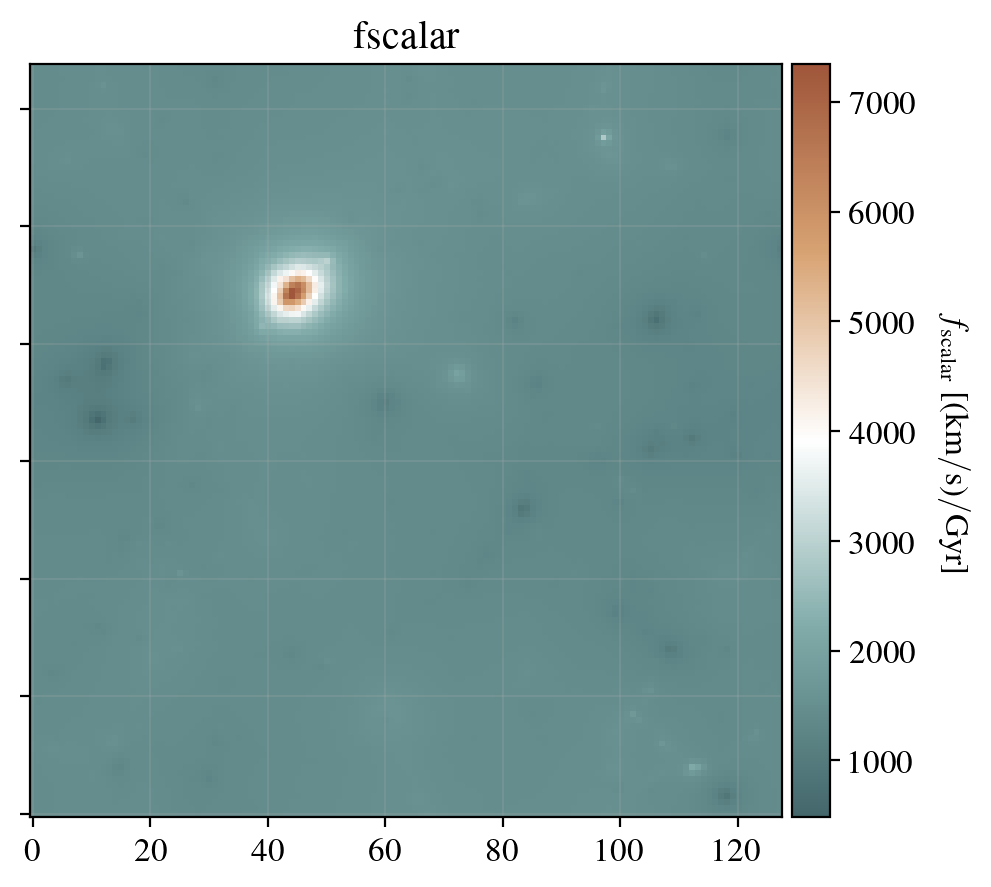

In [4]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

plt.clf()
fig = plt.figure(figsize=(4,4))
gs  = gridspec.GridSpec(1, 1,
                       top=0.95,
                       right=1.00,
                       left=0.00,
                       bottom=0.00,
                        hspace=0,
                        wspace=0.1
                       )


ax1 = plt.subplot(gs[0])

p2=ax1.imshow( np.real(R_fscalar[0,:,:])   ,cmap=suisai.cm.forestdawn)
ax1.set_title(r"${\rm fscalar}$")
plt.setp( ax1.get_yticklabels(), visible=False);
divider = make_axes_locatable(ax1)
cax  = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(p2, cax=cax)
cbar.set_label(r'$f_{\rm scalar}\ [{\rm (km/s)/Gyr} ]$', rotation=270,labelpad=20)



#plt.imshow(np.real(R_fscalar[0,:,:]) )

In [5]:
#del gas,tot,cdm
h=0.67
T   = np.load('/Users/yomori/Grids_T_IllustrisTNG_CV_128_z=0.0.npy') #[K]

# Gaspressure 
P   = np.load('/Users/yomori/Grids_P_IllustrisTNG_CV_128_z=0.0.npy').astype(np.float64) #[h^2Msun(km/s)^2/Mpc^3] -> [keV/cm^3]
#gas = np.load('/Users/yomori/Grids_Mgas_IllustrisTNG_CV_128_z=0.0.npy')

#rhom   = cdm[seed,:,:,:] #These maps are in units of Msun/(Mpc/h)^3

#camels in units of 
#T=>K
#P=>h^2Msun(km/s)^2/Mpc^3

#P=P*1.6047e-16/1000**2/1.99e30*(3.086e24)**3
#P_kev=P*1.99e30/1.782e-36*1000**2/(3e8)**2/(3.086e24)**3/1000 # keV/cm^3
#P_kev = P*1000**2*1.99e30/3e8/3e8/1.783e-36/1000/(3.086e24)**3 
#conv=1.99e30/1.782e-36*1000**2/(3e8)**2/(3.086e24)**3/1000
#conv  = 1000**2*1.99e30/3e8/3e8/1.783e-36/1000/(3.086e24)**3

P_kev = P*1000**2           #[h^2Msun(km/s)^2/Mpc^3] -> [h^2Msun(m/s)^2/Mpc^3]
P_kev = P_kev/(3e8)**2      #[h^2Msun(m/s)^2/Mpc^3]  -> [h^2Msun(c)^2/Mpc^3]
P_kev = P_kev*1.99e30       #[h^2Msun(c)^2/Mpc^3]    -> [h^2 (kg) (c)^2/Mpc^3]
P_kev = P_kev/1.783e-36     #[h^2 (kg) (c)^2/Mpc^3]  -> [h^2 (eV) /Mpc^3]
P_kev = P_kev/(3.086e24)**3 #[h^2 (eV) /Mpc^3]       -> [h^2 (eV) /cm^3]
P_kev = P_kev/1000/h**2     #[h^2 (eV) /cm^3]        -> [(keV) /cm^3]


# Create fake T and P maps

In [12]:
rhog   = gas[seed,:,:,:]#These maps are in units of (Msun/h)/(Mpc/h)^3


In [13]:
"""
# hpm.f90
table2( 1,i,j) = 10**hpmtab%b(i,j)%M   *Mscale
table2( 2,i,j) = 10**hpmtab%b(i,j)%r
table2( 3,i,j) = 10**hpmtab%b(i,j)%s
table2( 4,i,j) = 10**hpmtab%b(i,j)%x
table2( 5,i,j) = 10**hpmtab%b(i,j)%rho *dscale
table2( 6,i,j) = 10**hpmtab%b(i,j)%psi *psiscale
table2( 7,i,j) = 10**hpmtab%b(i,j)%dm 
table2( 8,i,j) = 10**hpmtab%b(i,j)%dg
table2( 9,i,j) = 10**hpmtab%b(i,j)%T   *Tscale
table2(10,i,j) = 10**hpmtab%b(i,j)%vsq *vscale**2
table2(11,i,j) = 10**hpmtab%b(i,j)%P   *Pscale
table2(12,i,j) = 10**hpmtab%b(i,j)%Pnth*Pscale
table2(13,i,j) = 10**hpmtab%b(i,j)%f   *fscale
table2(14,i,j) = 10**hpmtab%b(i,j)%fp  *fscale
""";
        
# Load hpm table
f  = open('/Users/yomori/repo/Baryonator/notebooks/hpm_table_z=00.01.dat', 'rb')
dd = np.fromfile(f, dtype=np.int32,count=2);print(dd)
X  = np.fromfile(f, dtype=np.float32) 
Y  = X.reshape((dd[1],dd[0],14))

# Set up an interpolator
drho = Y[0,:,4]
psi  = Y[:,0,5]

Tt   = Y[:,:,8].astype(np.float64)  # [K]

'''
Pt   = Y[:,:,10].astype(np.float64) # [keV/cm^3]
Pt   = Pt*1000                      # [eV/cm^3]
Pt   = Pt*(3e8)**2                  # [(eV/c^2)*(m/s)^2/cm^3]
Pt   = Pt*1.783e-36                 # [(kg)*(m/s)^2/cm^3]
Pt   = Pt/1.99e30                   # [(Msun)*(m/s)^2/cm^3]
Pt   = Pt/(1000)**2                 # [(Msun)*(km/s)^2/cm^3]
Pt   = Pt*(3.086e24)**3             # [(Msun)*(km/s)^2/Mpc^3]
Pt   = Pt/h**2                      # [h^2(Msun)*(km/s)^2/Mpc^3]
'''

Pt   = Y[:,:,10].astype(np.float64) # [keV/cm^3]
Pt   = Pt*1000                      # [eV/cm^3]
Pt   = Pt*(1.602e-19)               # [kg m^2/s^2 /cm^3]
Pt   = Pt/1.98847e30                # [Msun m^2/s^2 /cm^3]
Pt   = Pt/1000/1000                 # [Msun km^2/s^2 /cm^3]
Pt   = Pt*(3.086e24)**3             # [Msun km^2/s^2 /Mpc^3]
Pt   = Pt/h**2                      # [h^2(Msun)*(km/s)^2/Mpc^3]


#--------------> Pt is x10^10 high

from scipy.interpolate import RegularGridInterpolator
intpT = RegularGridInterpolator((psi,drho), Tt, bounds_error=False, fill_value=0)
intpP = RegularGridInterpolator((psi,drho), Pt, bounds_error=False, fill_value=0)

R_fscalar = R_fscalar.real
Tf = intpT( np.c_[(R_fscalar.real).flatten(), (rhog/np.mean(rhog)).flatten() ]).reshape((128,128,128))
Pf = intpP( np.c_[(R_fscalar.real).flatten(), (rhog/np.mean(rhog)).flatten() ]).reshape((128,128,128))

############ is avg(rhom)===rhobar?


#Pf = intpP( np.c_[(rhom/np.mean(rhom)).flatten(),  (R_fscalar.real).flatten() ]).reshape((128,128,128))
print('log10(R_fscalar):',np.log10(np.min((R_fscalar.real).flatten())),np.log10( np.max((R_fscalar.real).flatten()) ) )
print('log10(rhom/rhom_bar):',np.log10(np.min((rhom/np.mean(rhom)).flatten() )), np.log10(np.max( (rhom/np.mean(rhom)).flatten() ) ) )
print(np.max(np.log10(np.real(Pf[0,:,:])) ))

[145  70]
log10(R_fscalar): -inf 4.716617414558448
log10(rhom/rhom_bar): -1.8917772 4.075492
19.003872244454453


/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_20213/3848884211.py:65: RuntimeWarning: divide by zero encountered in log10
  print('log10(R_fscalar):',np.log10(np.min((R_fscalar.real).flatten())),np.log10( np.max((R_fscalar.real).flatten()) ) )


0.0


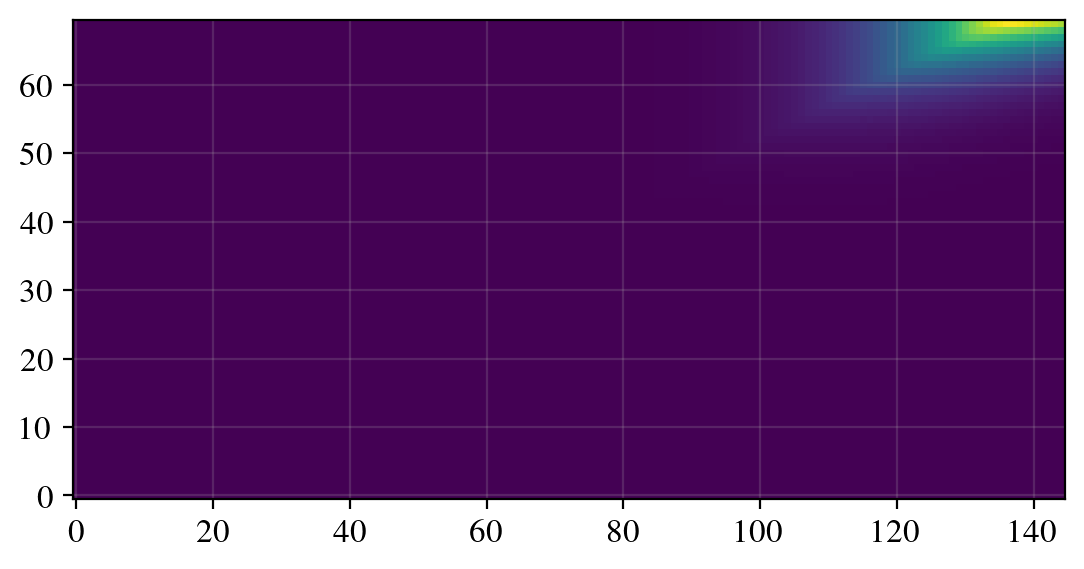

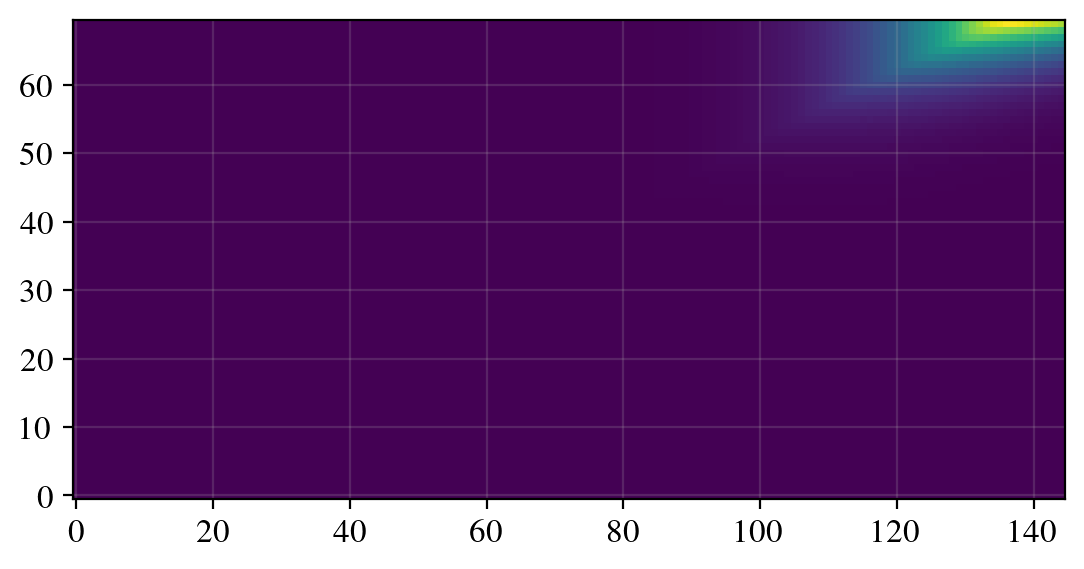

In [7]:
plt.figure()
plt.imshow(Y[:,:,10])


plt.figure()
# Check the ordering of interpolation
testP = RegularGridInterpolator((psi,drho), Y[:,:,10], fill_value=0,bounds_error=False)

ret=np.zeros_like(Y[:,:,10])
for x in range(drho.shape[0]):
    for y in range(psi.shape[0]):
        ret[y,x]=testP([psi[y],drho[x]])
     
plt.imshow(ret)

print(np.max(np.abs(ret-Y[:,:,10]  )))

In [8]:
print("pressure-fscalar:", np.max(Pf) ) 
print("pressure-hydro  :", np.max(P)  )

pressure-fscalar: 4.7991771778273005e+20
pressure-hydro  : 733400399872.0


/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_20213/846085806.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p4, cax=cax)


(-9.0, 0.0)

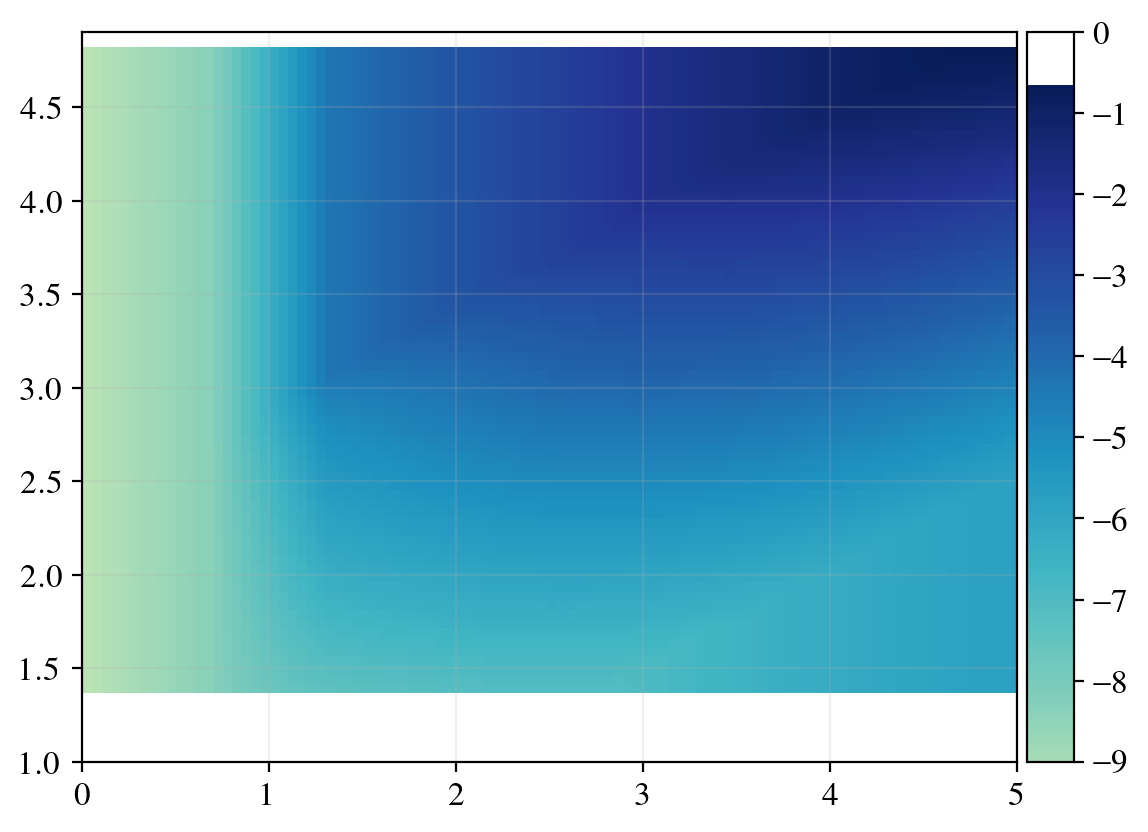

In [9]:
#plt.imshow(Y[:,:,10])

p4=plt.imshow( np.log10(Y[:,:,10]), cmap='YlGnBu',extent=[np.log10(drho[0]),np.log10(drho[-1]),np.log10(psi[0]),np.log10(psi[-1]) ]  )
#plt.loglog()
plt.xlim(0,5)
plt.ylim(1,np.log10(8e4) )
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p4, cax=cax)
plt.ylim(-9,0)


/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_20213/2874570748.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p1, cax=cax)
/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_20213/2874570748.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p2, cax=cax)
/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_20213/2874570748.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p3, cax=cax)
/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_20213/2874570748.py:44: MatplotlibDeprecationWarning: Auto-rem

<Figure size 640x480 with 0 Axes>

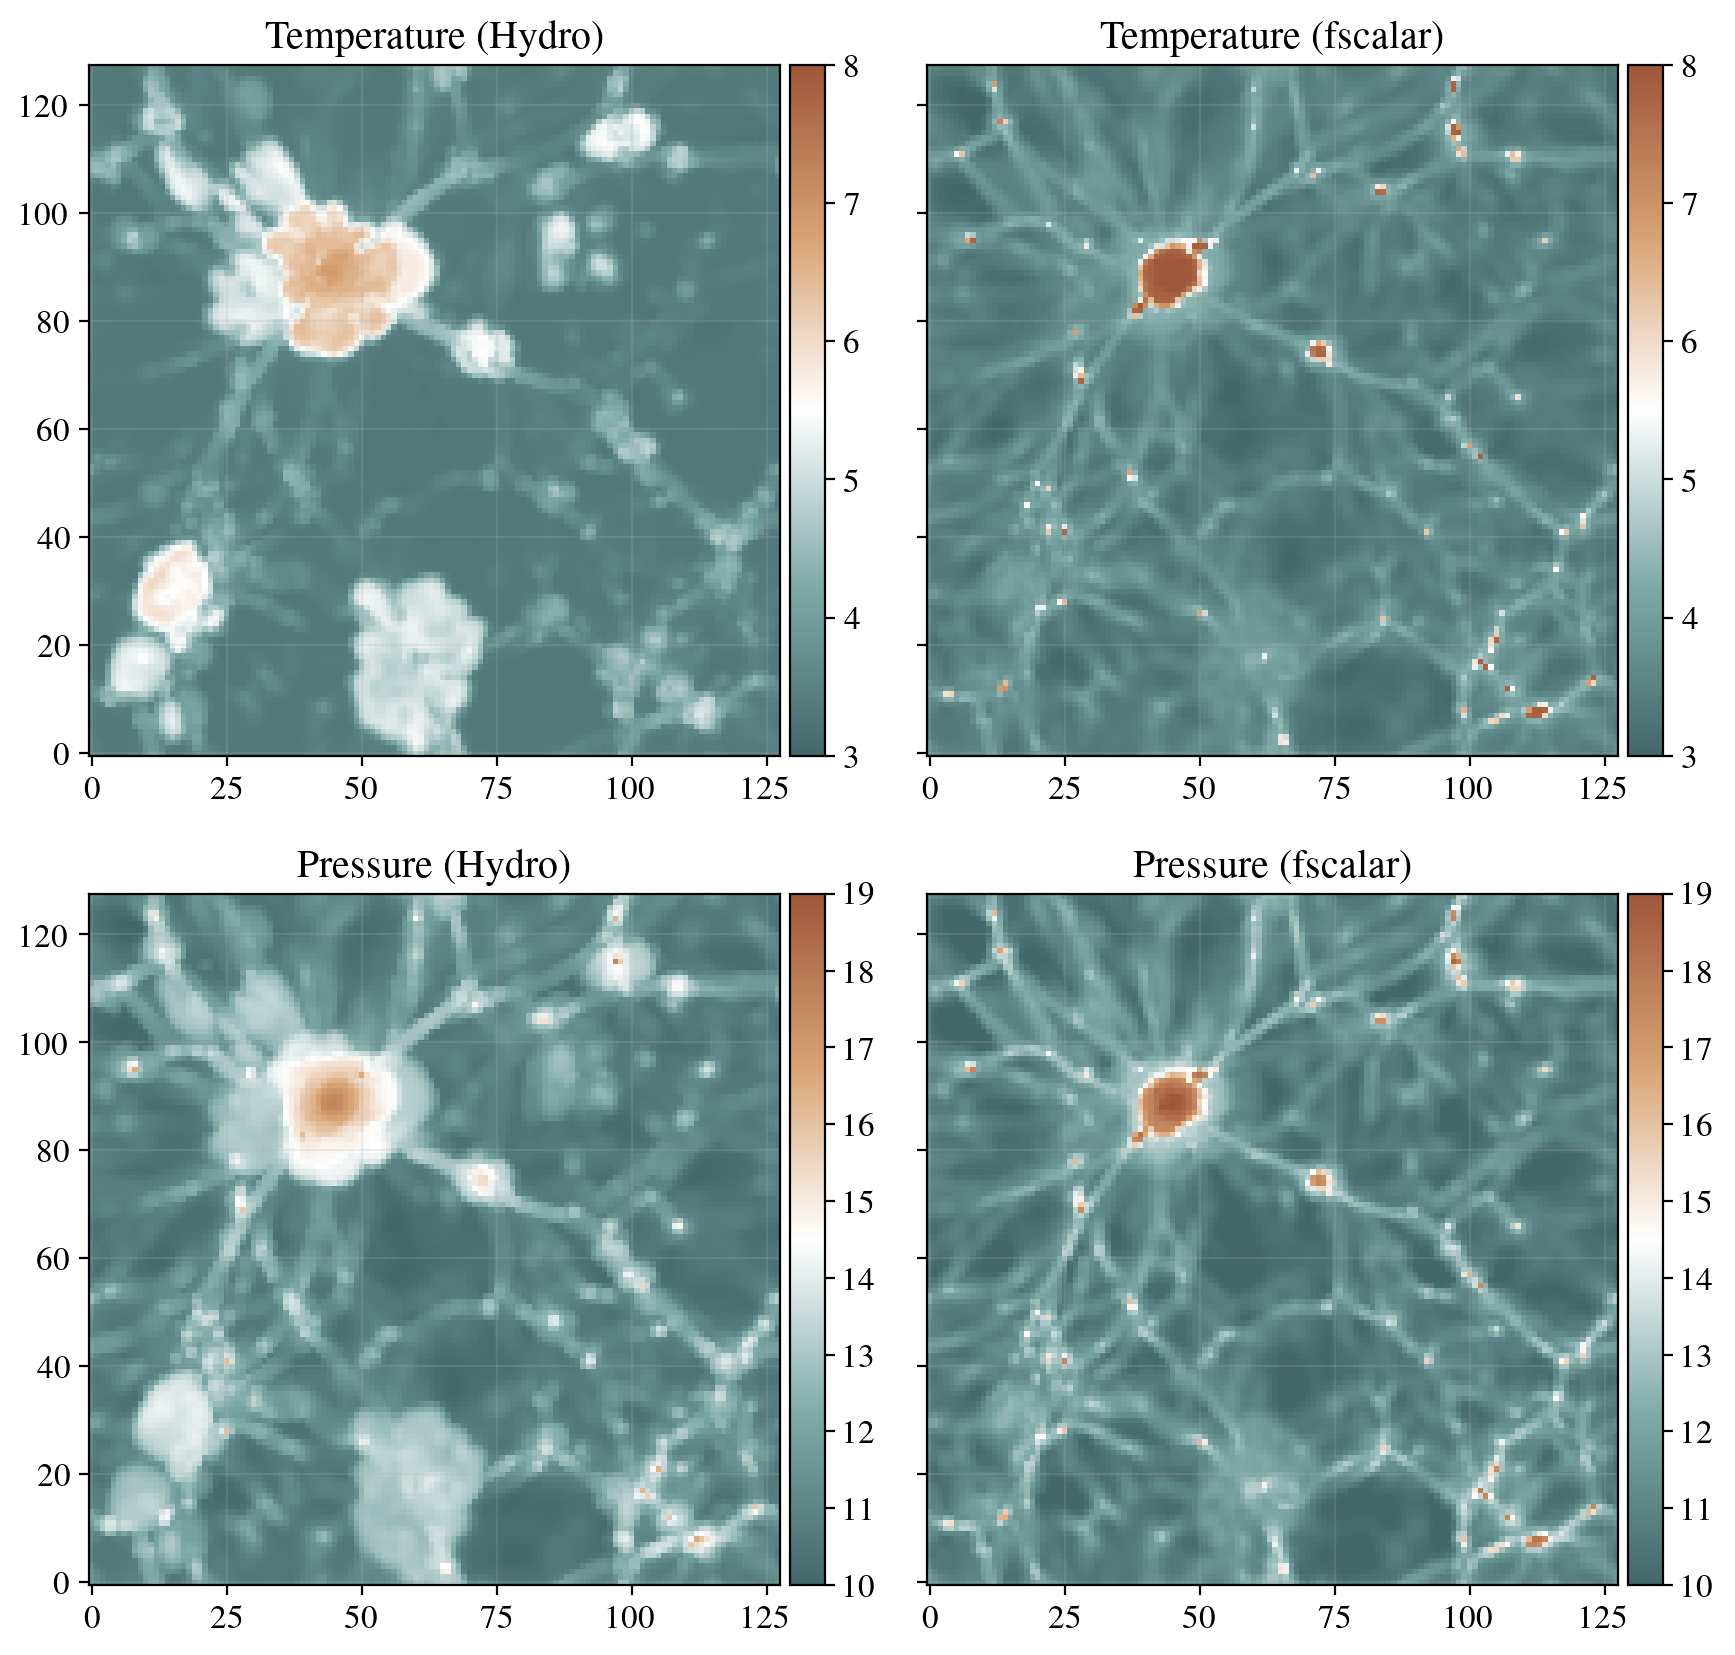

In [14]:

plt.clf()
fig = plt.figure(figsize=(8,8))
gs  = gridspec.GridSpec(2, 2,
                       top=0.95,
                       right=1.00,
                       left=0.00,
                       bottom=0.00,
                        hspace=0.2,
                        wspace=0.1
                       )


ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

p1=ax0.imshow(np.log10(T[0,0,:,:]),cmap=suisai.cm.forestdawn,vmin=3,vmax=8)
ax0.set_title(r"${\rm Temperature\ (Hydro)}$")
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p1, cax=cax)

p2=ax1.imshow(np.log10(np.real(Tf[0,:,:])),cmap=suisai.cm.forestdawn,vmin=3,vmax=8)
ax1.set_title(r"${\rm Temperature\ (fscalar)}$")
plt.setp( ax1.get_yticklabels(), visible=False);
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p2, cax=cax)


p3=ax2.imshow(np.log10(P[0,0,:,:]*1e9),cmap=suisai.cm.forestdawn,vmin=10,vmax=19)
ax2.set_title(r"${\rm Pressure\ (Hydro)}$")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p3, cax=cax)

#p4=ax3.imshow(np.log(np.real(Pf[0,:,:]*1.6047e-16/1000**2/1.99e30*(3.086e24)**3)),cmap=suisai.cm.forestdawn)
p4=ax3.imshow(np.log10(np.real(Pf[0,:,:])),cmap=suisai.cm.forestdawn,vmin=10,vmax=19)
ax3.set_title(r"${\rm Pressure\ (fscalar)}$")
plt.setp( ax3.get_yticklabels(), visible=False);
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p4, cax=cax)




#plt.imshow(np.real(R_fscalar[0,:,:]) )

## Compton-y

In [15]:

sigT  = 6.65e-29 # m^2
me    = 9.11e-31 # kg
c     = 3e8      # m^2/s^2
dl    = 25/128   # Mpc/h
h     = 0.6777

#  Compton-y for HYPER
y     = np.sum(P[0,:,:,:],axis=2)*dl   # [h Msun (km/s)^2/Mpc^2]
y     = y*sigT/(3.0886e22)**2          # [h Msun (km/s)^2/Mpc^2] -> [h Msun (km/s)^2 ]
y     = y/me*1.99e30                   # [h Msun (km/s)^2 ]      -> [h (km/s)^2 ]
y     = y*(1000)**2/c**2*h             # [h (km/s)^2 ]           -> unitless

#  Compton-y for fscalar
yf    = np.sum(Pf[:,:,:]/1e9,axis=2)*dl    # [h Msun (km/s)^2/Mpc^2]
yf    = yf*sigT/(3.0886e22)**2         # [h Msun (km/s)^2/Mpc^2] -> [h Msun (km/s)^2 ]
yf    = yf/me*1.99e30                  # [h Msun (km/s)^2 ]      -> [h (km/s)^2 ]
yf    = yf*(1000)**2/c**2*h            # [h (km/s)^2 ]           -> unitless


/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_20213/2469900412.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p0, cax=cax)
/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_20213/2469900412.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p1, cax=cax)


<Figure size 640x480 with 0 Axes>

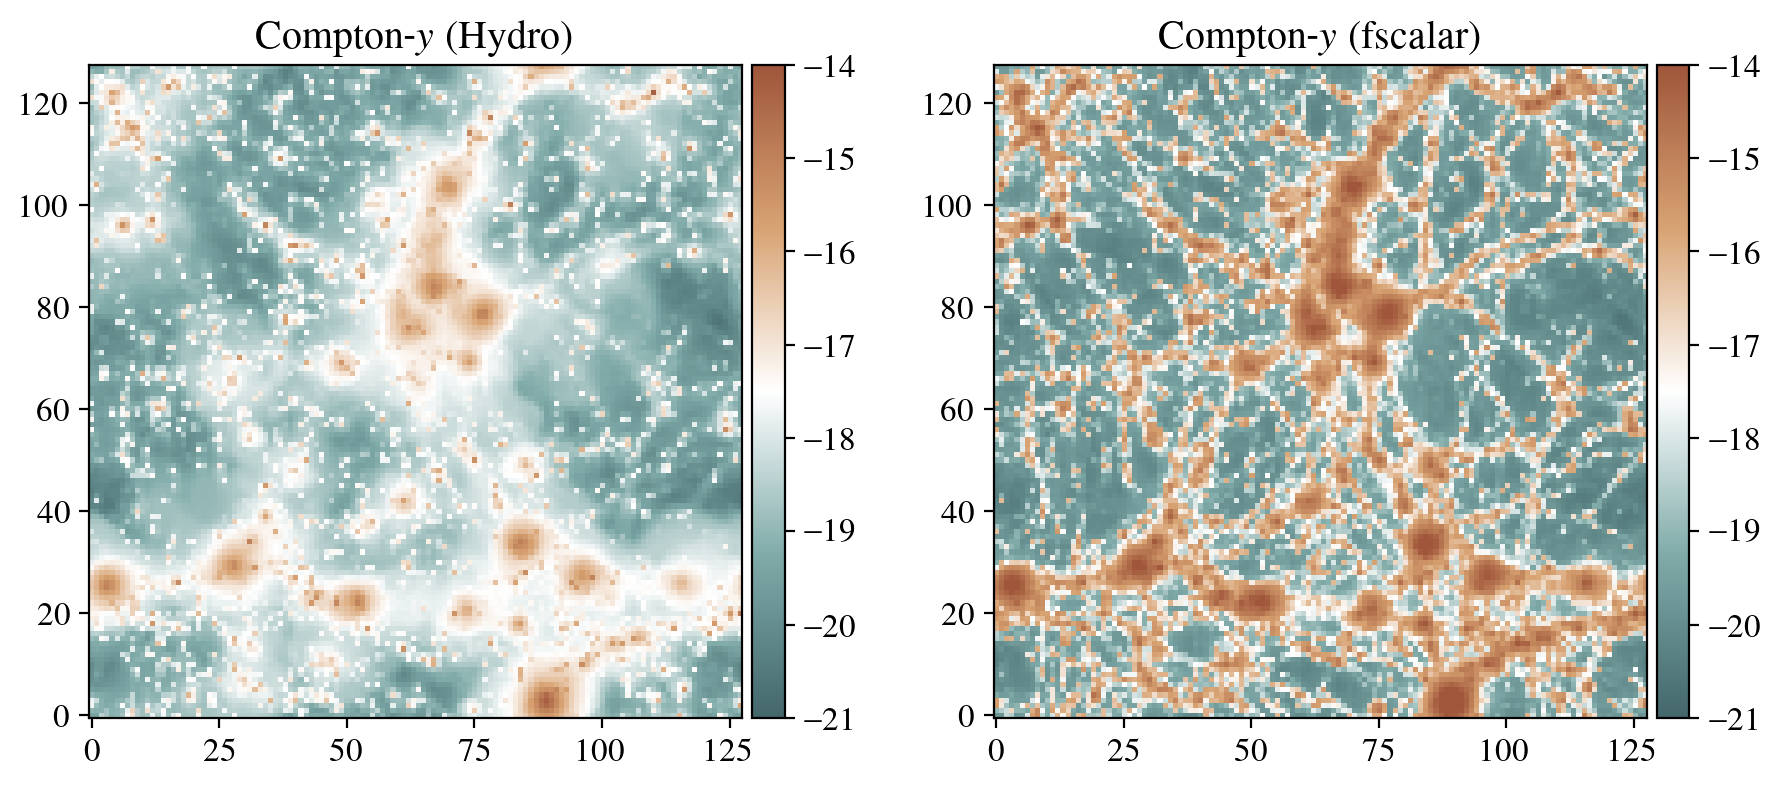

In [23]:
from scipy.ndimage import gaussian_filter as gf
plt.clf()
fig = plt.figure(figsize=(8,4))
gs  = gridspec.GridSpec(1, 2,
                       top=0.95,
                       right=1.00,
                       left=0.00,
                       bottom=0.00,
                        hspace=0.2,
                        wspace=0.3
                       )


ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

p0=ax0.imshow(np.log10(y),cmap=suisai.cm.forestdawn,vmin=-21,vmax=-14)
ax0.set_title(r"${\rm Compton}$-$y$\ ${\rm (Hydro)}$")
ax0.grid(False)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p0, cax=cax)


p1=ax1.imshow(np.log10(yf),cmap=suisai.cm.forestdawn,vmin=-21,vmax=-14)
ax1.set_title(r"${\rm Compton}$-$y$\ ${\rm (fscalar)}$")
ax1.grid(False)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p1, cax=cax)
plt.grid(False)




In [14]:
# Compare profiles at peaks
from skimage.feature import peak_local_max
xy = peak_local_max(np.log10(y), min_distance=2,threshold_abs=-15.5)

/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_60622/1183460418.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p0, cax=cax)
/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_60622/1183460418.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p1, cax=cax)


<Figure size 640x480 with 0 Axes>

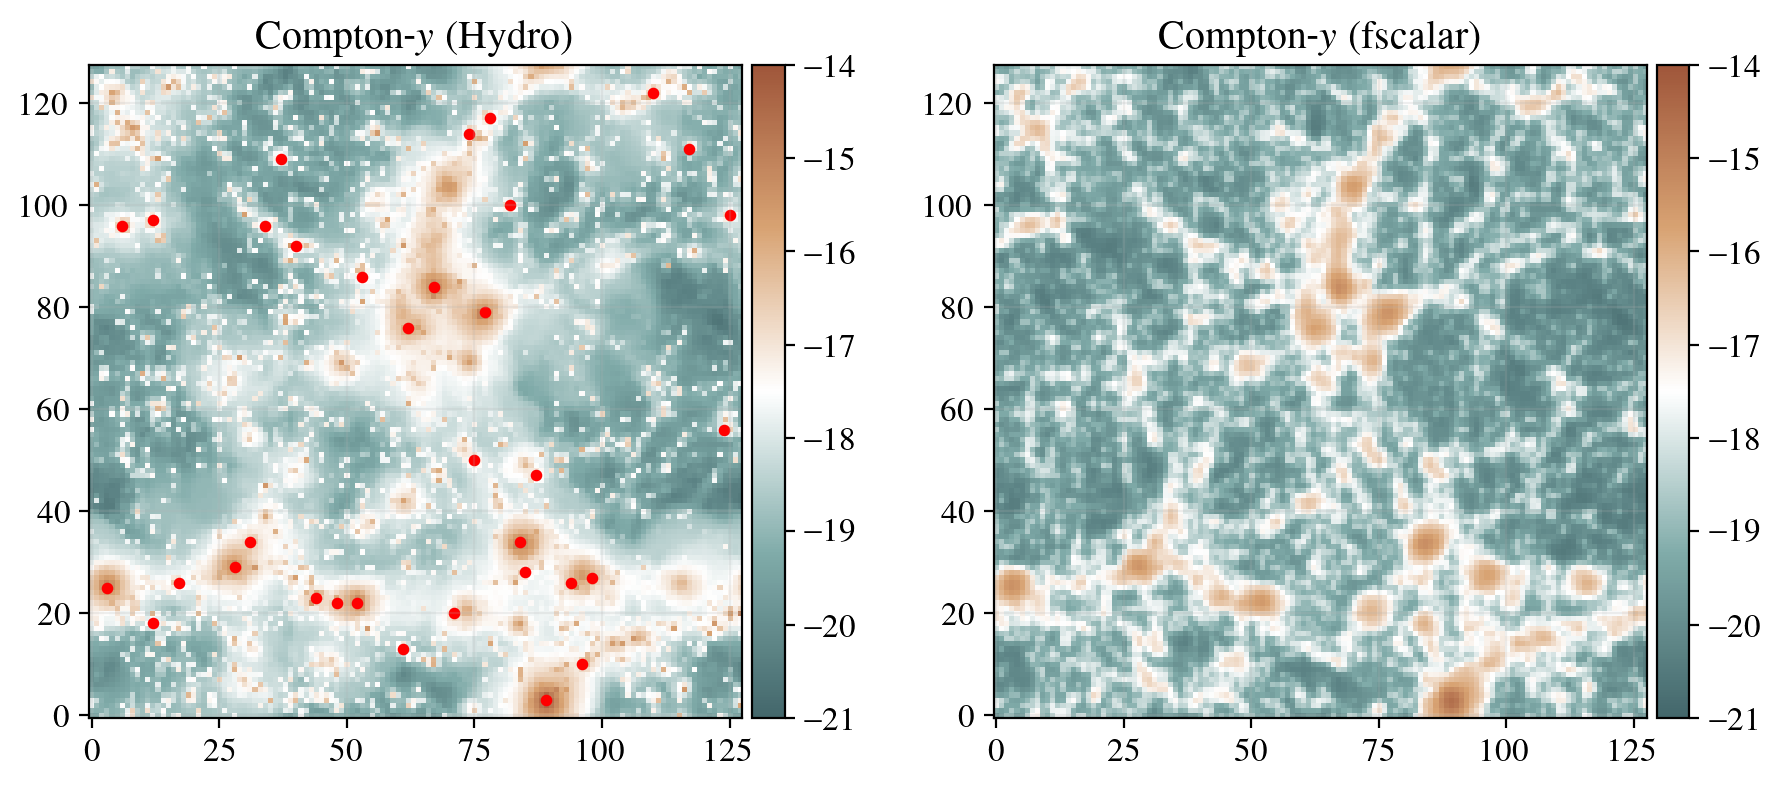

In [15]:
from scipy.ndimage import gaussian_filter as gf
plt.clf()
fig = plt.figure(figsize=(8,4))
gs  = gridspec.GridSpec(1, 2,
                       top=0.95,
                       right=1.00,
                       left=0.00,
                       bottom=0.00,
                        hspace=0.2,
                        wspace=0.3
                       )


ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

p0=ax0.imshow(np.log10(y),cmap=suisai.cm.forestdawn,vmin=-21,vmax=-14)
ax0.scatter(xy.T[1],xy.T[0],s=10,color='r')

ax0.set_title(r"${\rm Compton}$-$y$\ ${\rm (Hydro)}$")
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p0, cax=cax)

p1=ax1.imshow(gf(np.log10(yf),0.6),cmap=suisai.cm.forestdawn,vmin=-21,vmax=-14)
ax1.set_title(r"${\rm Compton}$-$y$\ ${\rm (fscalar)}$")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p1, cax=cax)




/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_60622/3775703650.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p0, cax=cax)
/var/folders/5m/7vgqf5nn1r9ff77y0pl1w0zw0000gn/T/ipykernel_60622/3775703650.py:45: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p1, cax=cax,label=r'${\rm log}_{10}(y)$')


<Figure size 640x480 with 0 Axes>

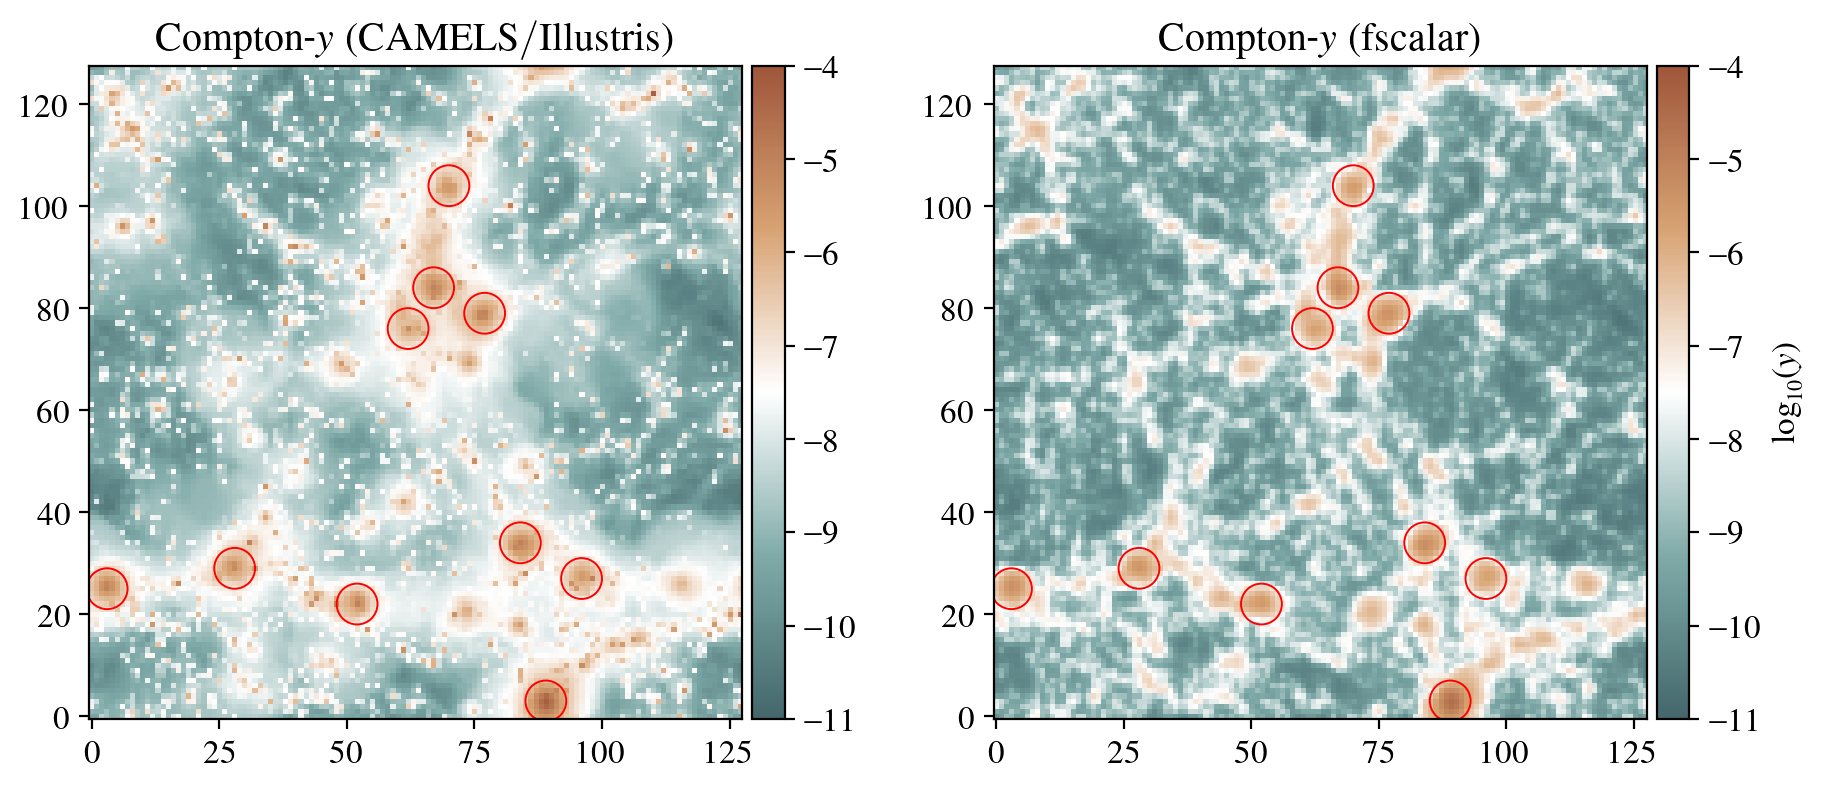

In [16]:
from scipy.ndimage import gaussian_filter as gf
plt.clf()
fig = plt.figure(figsize=(8,4))
gs  = gridspec.GridSpec(1, 2,
                       top=0.95,
                       right=1.00,
                       left=0.00,
                       bottom=0.00,
                        hspace=0.2,
                        wspace=0.3
                       )


from skimage.feature import peak_local_max
xy = peak_local_max(gf(np.log10(yf*1e10),0.6), min_distance=2,threshold_abs=-6)


ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

p0=ax0.imshow(np.log10(y*1e10),cmap=suisai.cm.forestdawn,vmin=-11,vmax=-4)
plt.grid(False)

for i in range(0,len(xy.T[1])):
    circle1 = plt.Circle((xy.T[1][i], xy.T[0][i]), 4, color='r',fc='None',lw=0.7)
    ax0.add_patch(circle1)
#ax0.scatter(xy.T[1],xy.T[0],s=10,color='r')

ax0.set_title(r"${\rm Compton}$-$y$\ ${\rm (CAMELS/Illustris)}$")
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p0, cax=cax)
ax0.grid(False)



p1=ax1.imshow(gf(np.log10(yf*1e10),0.6),cmap=suisai.cm.forestdawn,vmin=-11,vmax=-4)
for i in range(0,len(xy.T[1])):
    circle1 = plt.Circle((xy.T[1][i], xy.T[0][i]), 4, color='r',fc='None',lw=0.7)
    ax1.add_patch(circle1)
    
ax1.set_title(r"${\rm Compton}$-$y$\ ${\rm (fscalar)}$")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p1, cax=cax,label=r'${\rm log}_{10}(y)$')
ax1.grid(False)

#ax0.scatter(xy.T[1],xy.T[0],s=10,color='r')



In [17]:
nx, ny = (201, 201)             # grid size
midy   = 10#int((ny-1)/2)
midx   = 10#int((nx-1)/2)
sx = np.linspace(0, 20, nx)-midx # comving length
sy = np.linspace(0, 20, ny)-midy
xv, yv = np.meshgrid(sx, sy)
r=np.sqrt(xv**2+yv**2)

In [39]:
xy.T[1],xy.T[0]

(array([89, 67, 84,  3, 77, 28, 52, 70, 62, 96]),
 array([  3,  84,  34,  25,  79,  29,  22, 104,  76,  27]))

good
good
good
good
good
good
good
good


/Users/yomori/opt/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yomori/opt/anaconda3/envs/analysis/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

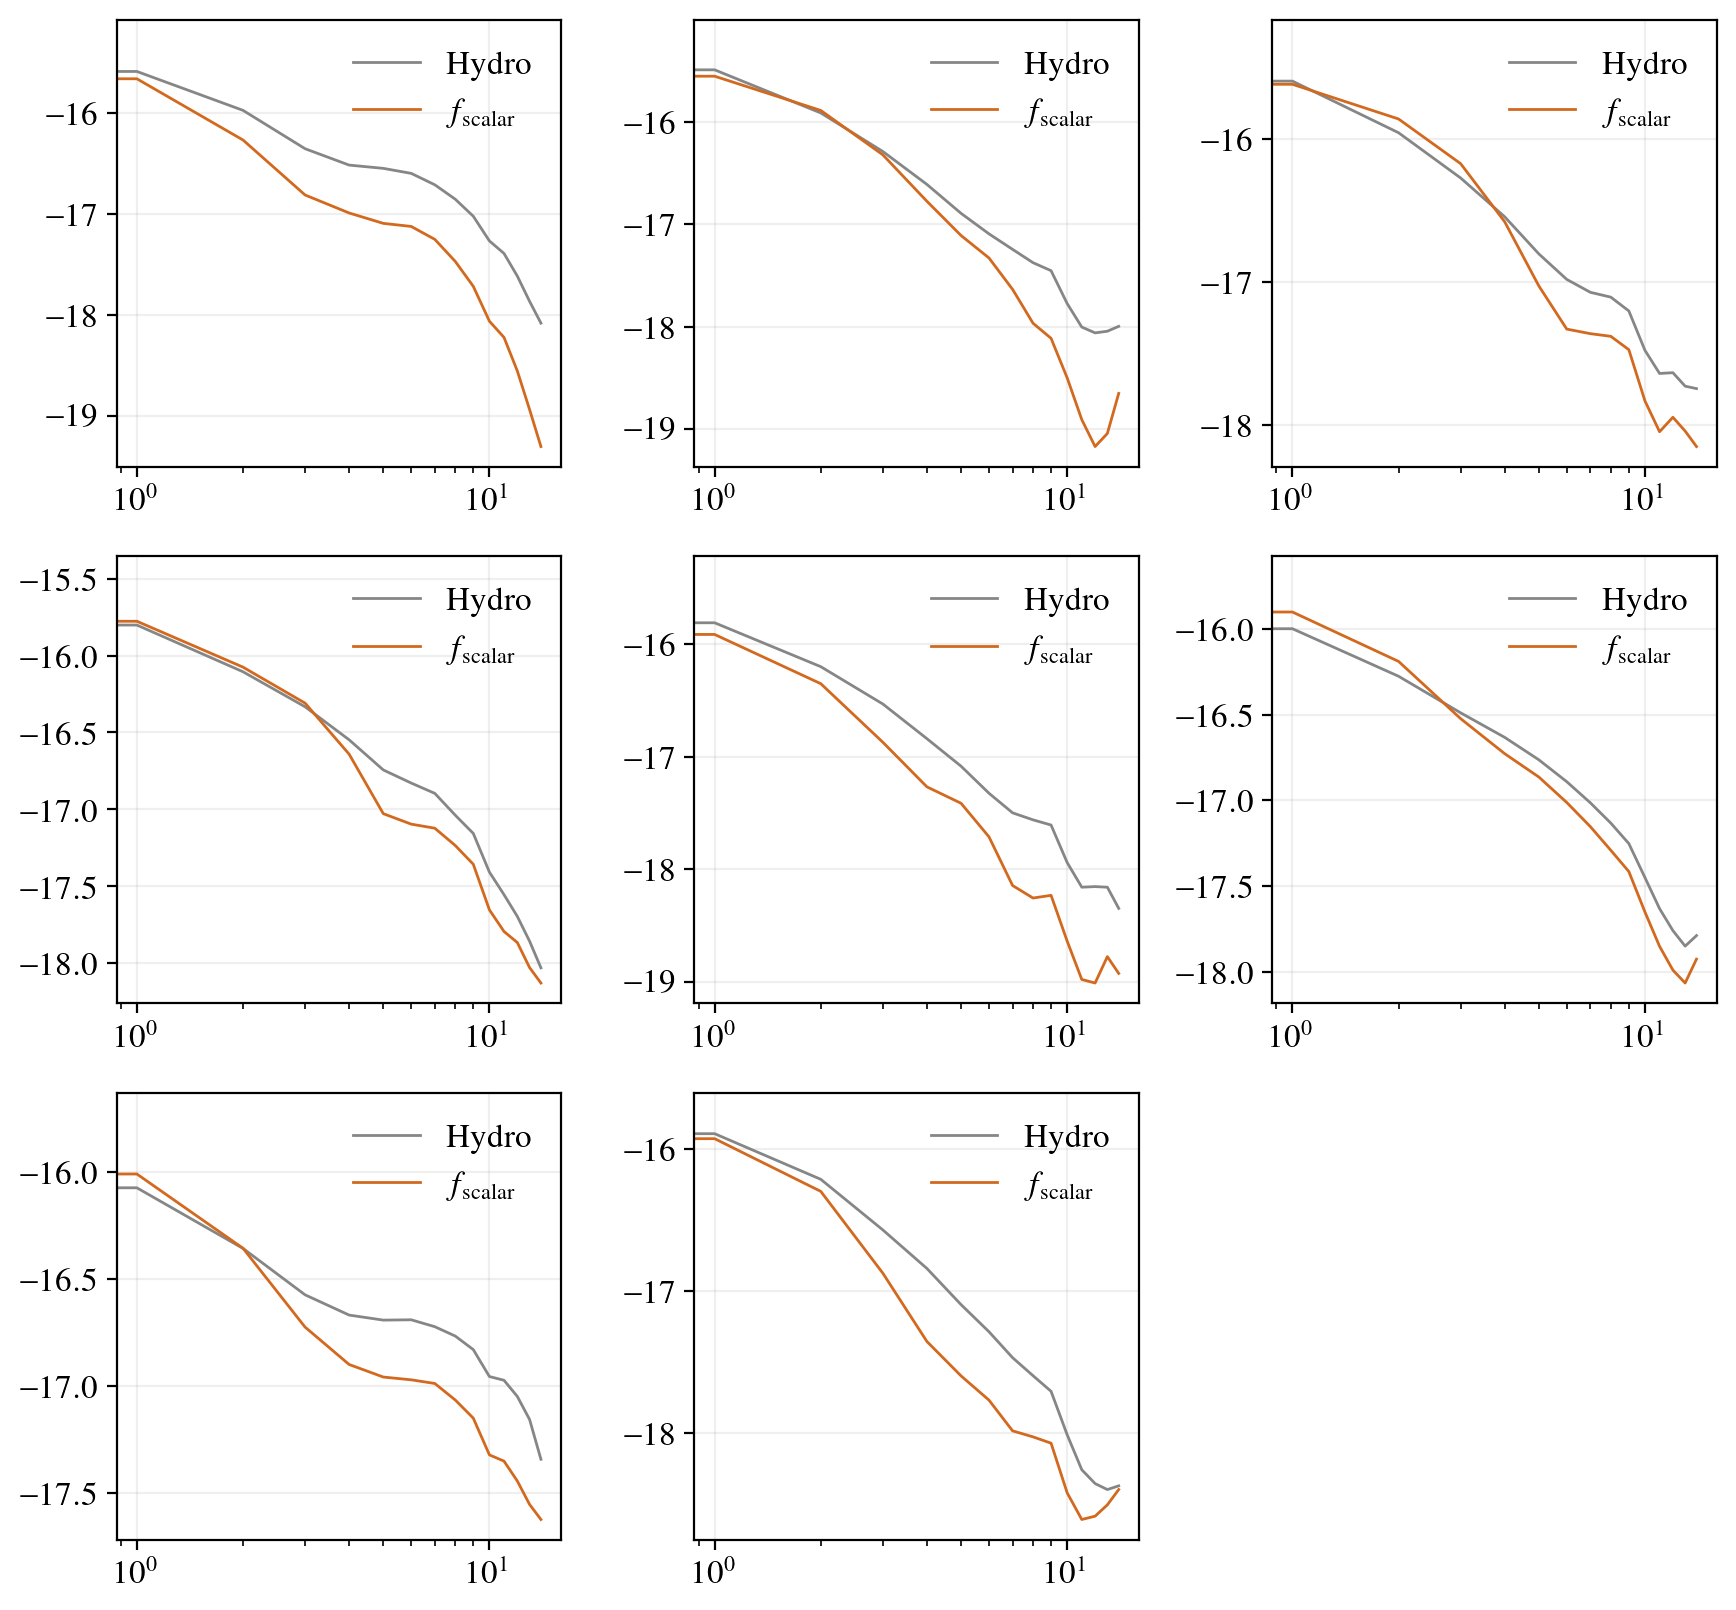

In [20]:
plt.clf()
fig = plt.figure(figsize=(8,8))
gs  = gridspec.GridSpec(3, 3,
                       top=0.95,
                       right=1.00,
                       left=0.00,
                       bottom=0.00,
                        hspace=0.2,
                        wspace=0.3
                       )


img =np.log10(y)
img2=gf(np.log10(yf),0.5)

c=0
for i in range(0,len(xy.T[1])):
    x0,y0  = xy.T[1][i],xy.T[0][i]
    tmp    = img[y0-10:y0+11,x0-10:x0+11]
    tmp2   = img2[y0-10:y0+11,x0-10:x0+11]
    
    
    if (tmp.shape[0]==21) and (tmp.shape[1]==21):
        print('good')
        xi,yi  = np.linspace(0,20,201),np.linspace(0,20,201)
        interp = RegularGridInterpolator((np.arange(21), np.arange(21)), tmp, bounds_error=False, fill_value=None)
        F      = interp((xi,yi))
 
        interp = RegularGridInterpolator((np.arange(21), np.arange(21)), tmp2, bounds_error=False, fill_value=None)
        F2     = interp((xi,yi))

        #interpolate high-res grid
        ret=np.zeros(20)
        ret2=np.zeros(20)
        
        for i in range(0,20):
            idx=np.where((r>i) & (r<i+1))[0]
            #print(idx)
            ret[i]=np.mean(F[idx])
            ret2[i]=np.mean(F2[idx])
            
        ax = plt.subplot(gs[c])
        ax.semilogx(np.arange(20),ret,label=r'${\rm Hydro}$')
        ax.semilogx(np.arange(20),ret2,label=r'$f_{\rm scalar}$',color='chocolate')
        #ax0.set_xlabel(r"$R\ [{\rm Mpc/h}]$")
        #ax0.set_ylabel(r"$\langle \log_{10}(y) \rangle $")
        plt.legend()
        c+=1
        
        if c>8:
            break
        


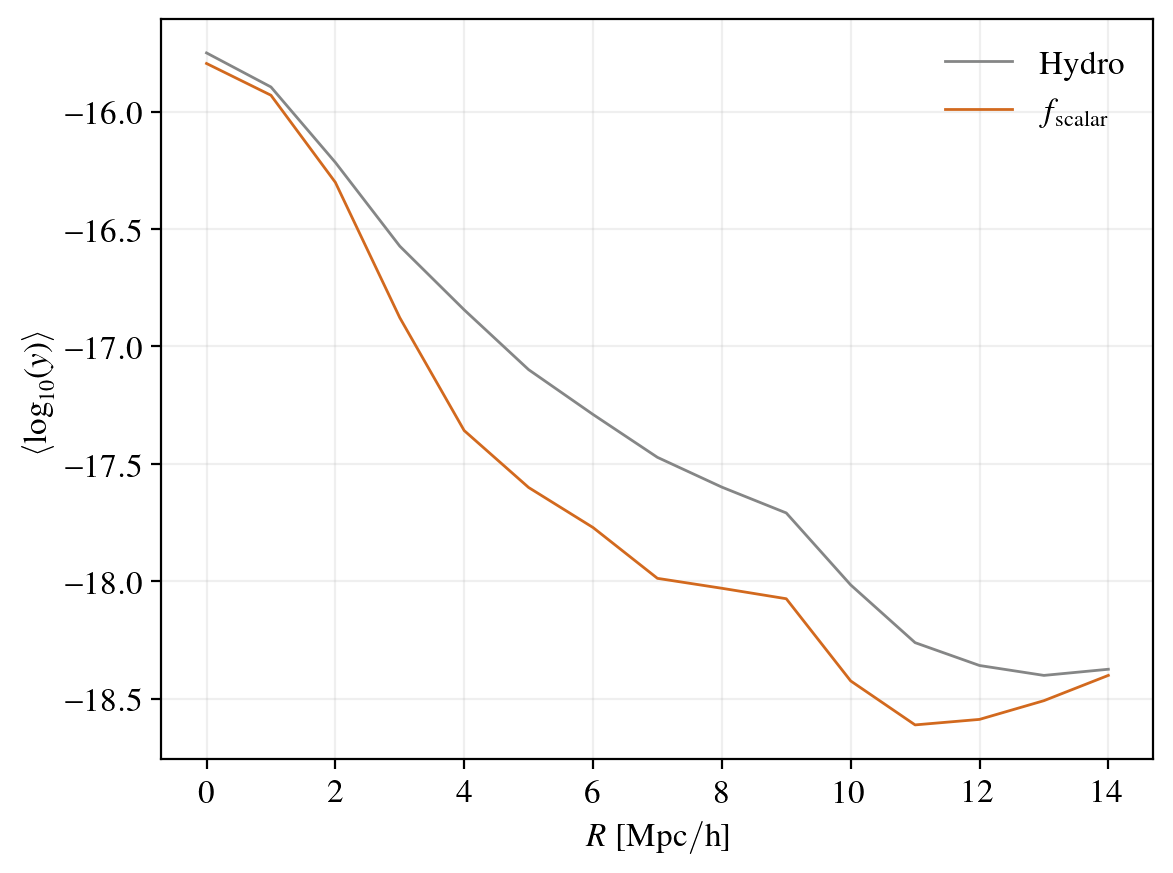

In [21]:
plt.plot(np.arange(20),ret,label=r'${\rm Hydro}$')
plt.plot(np.arange(20),ret2,label=r'$f_{\rm scalar}$',color='chocolate')
plt.xlabel(r"$R\ [{\rm Mpc/h}]$")
plt.ylabel(r"$\langle \log_{10}(y) \rangle $")
plt.legend()

good
good
good
good
good
good
good
good


<Figure size 640x480 with 0 Axes>

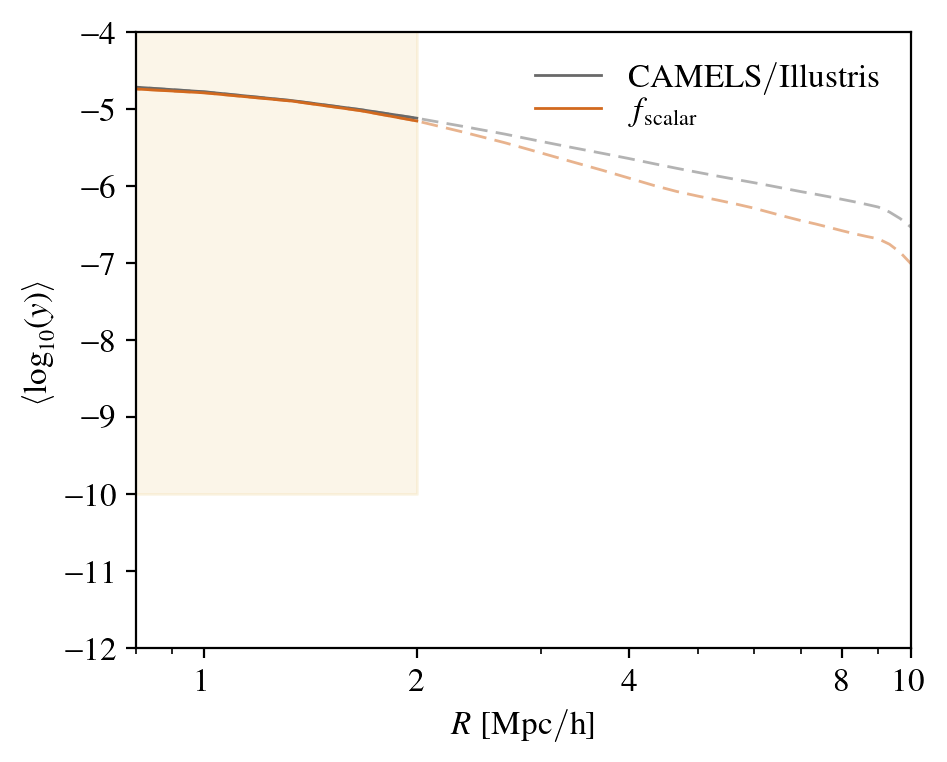

In [32]:
import matplotlib

plt.clf()
fig = plt.figure(figsize=(5,4))
gs  = gridspec.GridSpec(1, 1,
                       top=0.95,
                       right=1.00,
                       left=0.00,
                       bottom=0.00,
                        hspace=0.2,
                        wspace=0.3
                       )


img =np.log10(y)
img2=gf(np.log10(yf),0.5)

avgret=0
avgret2=0

c=0
for i in range(0,len(xy.T[1])):
    x0,y0  = xy.T[1][i],xy.T[0][i]
    tmp    = img[y0-10:y0+11,x0-10:x0+11]
    tmp2   = img2[y0-10:y0+11,x0-10:x0+11]
    
    
    if (tmp.shape[0]==21) and (tmp.shape[1]==21):
        print('good')
        xi,yi  = np.linspace(0,20,201),np.linspace(0,20,201)
        interp = RegularGridInterpolator((np.arange(21), np.arange(21)), tmp, bounds_error=False, fill_value=None)
        F      = interp((xi,yi))
 
        interp = RegularGridInterpolator((np.arange(21), np.arange(21)), tmp2, bounds_error=False, fill_value=None)
        F2     = interp((xi,yi))

        #interpolate high-res grid
        ret=np.zeros(60)
        ret2=np.zeros(60)
        
        for j in range(0,60):
            idx=np.where((r>j/3) & (r<j/3+1))[0]
            #print(idx)
            ret[j]=np.mean(F[idx])
            ret2[j]=np.mean(F2[idx])
            
        avgret +=ret
        avgret2+=ret2
        c+=1
        
        #ax = plt.subplot(gs[c])
        #ax.semilogx(np.arange(20),avgret,label=r'${\rm Hydro}$')
        #ax.semilogx(np.arange(20),avgret2,label=r'$f_{\rm scalar}$',color='chocolate')
        #ax0.set_xlabel(r"$R\ [{\rm Mpc/h}]$")
        #ax0.set_ylabel(r"$\langle \log_{10}(y) \rangle $")

plt.fill_between([0,2],[-10,-10],color='goldenrod',alpha=0.1)

plt.plot(np.arange(60)/3,avgret/c+11,color='dimgray',alpha=0.5,ls='--',dashes=(6,3))
plt.plot(np.arange(60)/3,avgret2/c+11,color='chocolate',alpha=0.5,ls='--',dashes=(6,3))

plt.plot(np.arange(60)[:7]/3,avgret[:7]/c+11,label=r'${\rm CAMELS/Illustris}$',color='dimgray')
plt.plot(np.arange(60)[:7]/3,avgret2[:7]/c+11,label=r'$f_{\rm scalar}$',color='chocolate')


plt.xlabel(r"$R\ [{\rm Mpc/h}]$")
plt.ylabel(r"$\langle \log_{10}(y) \rangle $")
plt.legend(loc='upper right', labelspacing=0.05)
plt.semilogx()
plt.grid(False)
plt.xlim(0.8,10)
plt.ylim(-8,-4)

plt.gca().set_xscale('log')
plt.gca().set_xticks([1,2,4 ,8, 10])
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

3
0.02962522511950283 218.1234767832227
3
26.318685425293694 538.9746508032224
3
58.82839208153703 852.3007949510984
3
67.49563607957569 1913.7087541549656
3
1507.2229023126733 3603.829208045309


<Figure size 640x480 with 0 Axes>

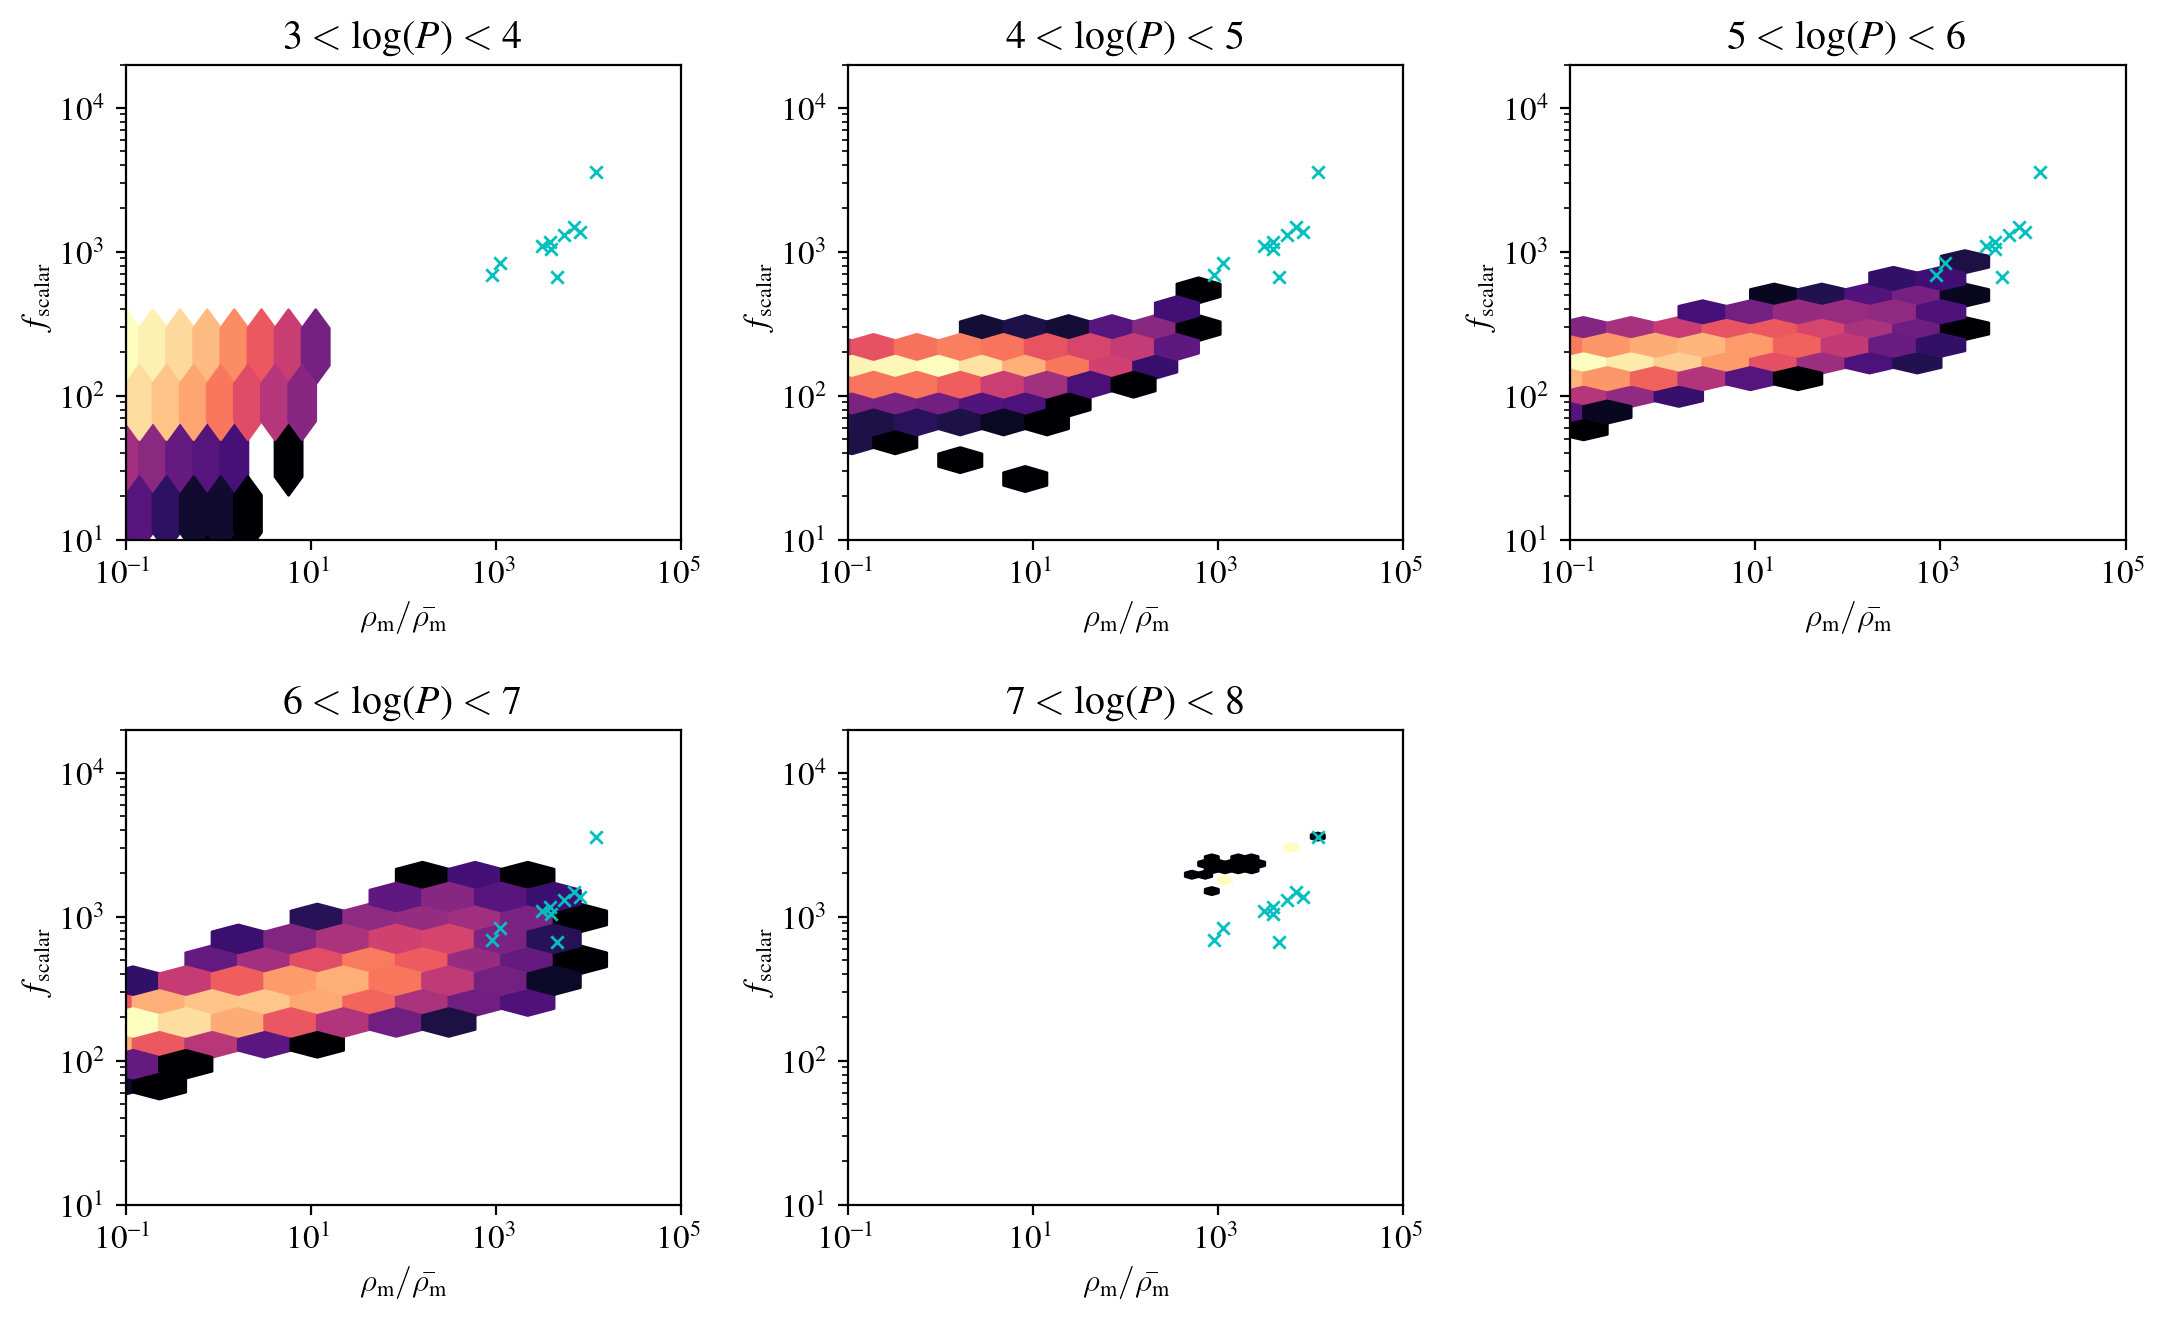

In [179]:
# CHeck whether fixed T or P values corresponds to unique point in rho/fscalar 

plt.clf()
fig = plt.figure(figsize=(10,6))
gs  = gridspec.GridSpec(2, 3,
                       top=0.95,
                       right=1.00,
                       left=0.00,
                       bottom=0.00,
                        hspace=0.4,
                        wspace=0.3
                       )

Tr=[1e3,1e4,1e5,1e6,1e7,1e8]

for i in range(0,5):
    ax0 = plt.subplot(gs[i])
    idx=np.where((T[0,:,:,:]>Tr[i])&(T[0,:,:,:]<Tr[i+1]) & (R_fscalar>0) )
    print(len(idx))
    print(np.min(R_fscalar[idx[0],idx[1],idx[2]]), np.max(R_fscalar[idx[0],idx[1],idx[2]]))
    #ax0.scatter(rhom[idx[0],idx[1],idx[2]]/np.mean(rhom),R_fscalar[idx[0],idx[1],idx[2]],s=1,alpha=0.4)
            
    ax0.hexbin(rhom[idx[0],idx[1],idx[2]]/np.mean(rhom), R_fscalar[idx[0],idx[1],idx[2]], C=None, gridsize=10, xscale='log', yscale='log',bins='log',cmap='magma')

    plt.loglog()
    plt.ylim(1e1,20000)
    plt.xlim(1e-1,1e5)
    
    plt.grid(False)
    #ax0.set_title('$%d<T [K]<%d$'%(Tr[i],Tr[i+1]))
    ax0.set_title(r'$%d<{\rm log}(P)<%d$'%(int(np.log10(Tr[i])),int(np.log10(Tr[i+1]) ) ))
    
    plt.xlabel(r"$\rho_{\rm m}/\bar{\rho_{\rm m}}$")
    plt.ylabel(r"$f_{\rm scalar}$")

    ax0.scatter(mret[:,0],mret[:,1],color='c',marker='x',s=20)

100663
22519
5111
795
97
2


<Figure size 640x480 with 0 Axes>

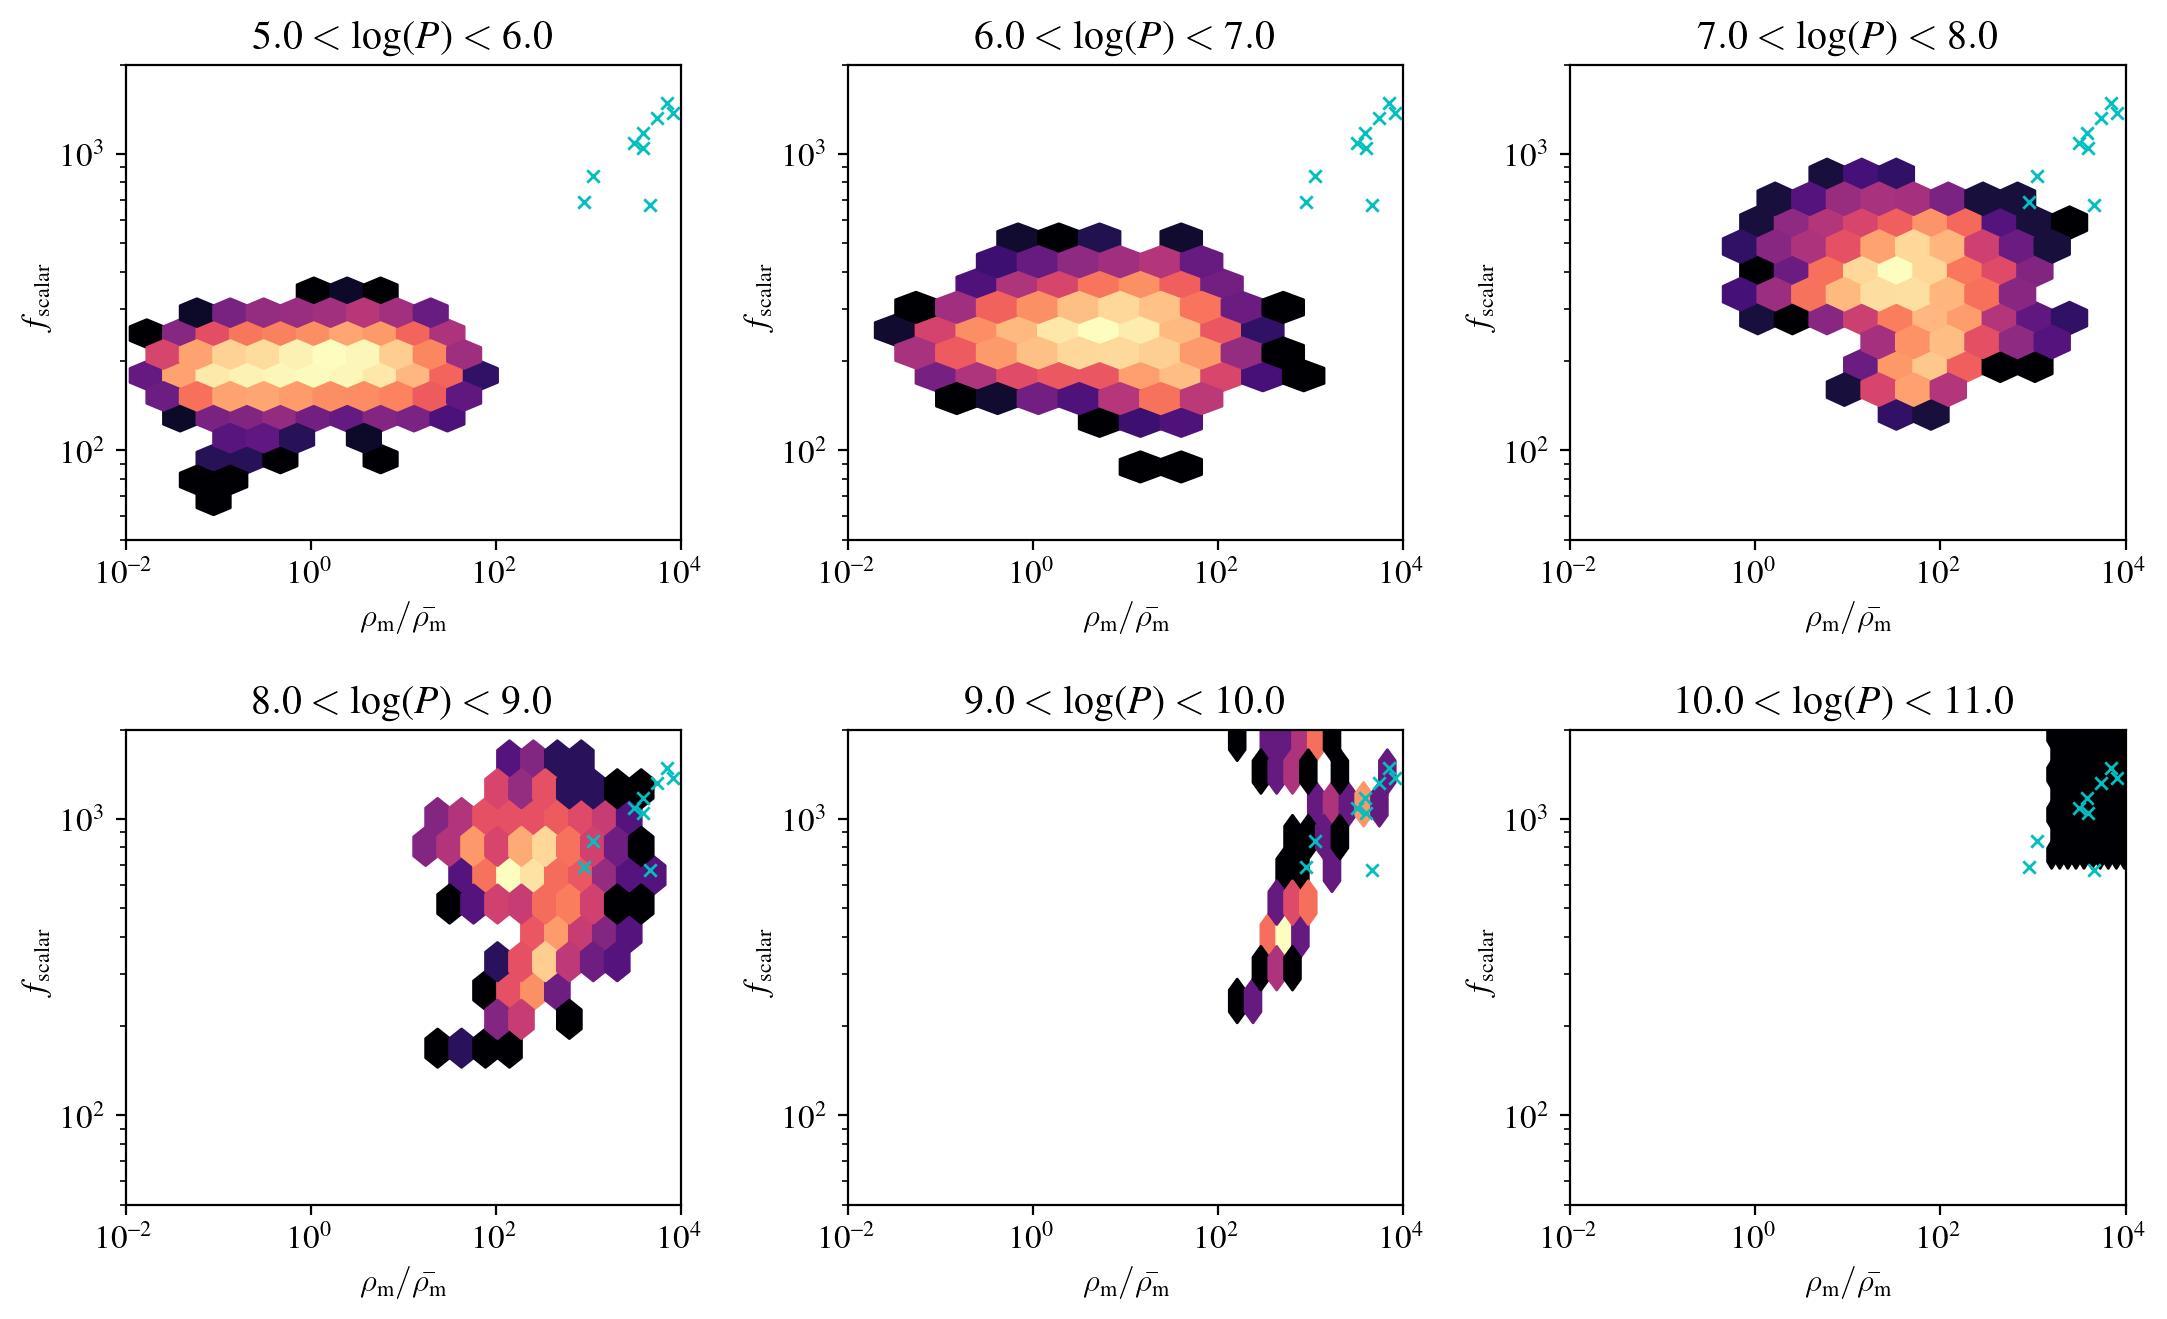

In [183]:
# CHeck whether fixed T or P values corresponds to unique point in rho/fscalar 

plt.clf()
fig = plt.figure(figsize=(10,6))
gs  = gridspec.GridSpec(2, 3,
                       top=0.95,
                       right=1.00,
                       left=0.00,
                       bottom=0.00,
                        hspace=0.4,
                        wspace=0.3
                       )

Tr=[1e5,1e6,1e7,1e8,1e9,1e10,1e11]

for i in range(0,6):
    ax0 = plt.subplot(gs[i])
    idx=np.where((P[0,:,:,:]>Tr[i])&(P[0,:,:,:]<Tr[i+1]))
    #ax0.scatter(rhom[idx[0],idx[1],idx[2]]/np.mean(rhom),R_fscalar[idx[0],idx[1],idx[2]],s=1,alpha=0.4)
    
    ax0.hexbin(rhom[idx[0],idx[1],idx[2]]/np.mean(rhom), R_fscalar[idx[0],idx[1],idx[2]], C=None, gridsize=10, xscale='log', yscale='log',bins='log',cmap='magma')
    print(len(idx[0]))
    
    plt.loglog()
    plt.xlim(1e-2,1e4)
    plt.ylim(50,2000)
    plt.grid(False)
    ax0.set_title(r'$%s<{\rm log}(P)<%s$'%(str(np.log10(Tr[i])),str(np.log10(Tr[i+1]) ) ))
    
    plt.xlabel(r"$\rho_{\rm m}/\bar{\rho_{\rm m}}$")
    plt.ylabel(r"$f_{\rm scalar}$")
    
    ax0.scatter(mret[:,0],mret[:,1],color='c',marker='x',s=20)

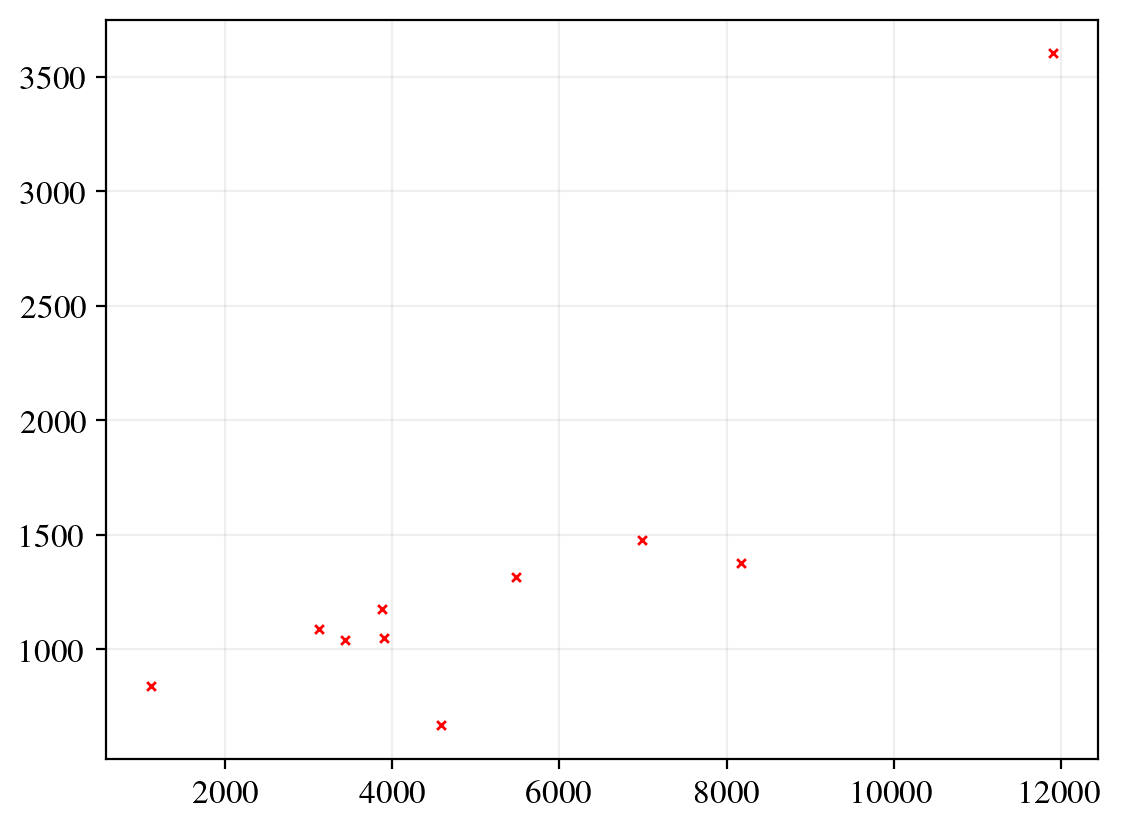

In [164]:
plt.scatter(mret[:,0],mret[:,1],color='r',marker='x',s=10)

In [41]:
xy.T[1],xy.T[0]

(array([89, 67, 84,  3, 77, 28, 52, 70, 62, 96]),
 array([  3,  84,  34,  25,  79,  29,  22, 104,  76,  27]))

In [170]:
mret=np.zeros((len(xy.T[1]),2))
xp=np.zeros(len(xy.T[1]))
yp=np.zeros(len(xy.T[1]))
zp=np.zeros(len(xy.T[1]))

for i in range(0,len(xy.T[1]) ):
    
    #zz = np.argmax(np.log10(gas[0,int(yp[idx]),int(xp[idx]),:]) )
    
    #print(xy.T[1][i], xy.T[0][i], zz, np.max(P[0,xy.T[1][i],xy.T[0][i],:]), np.argmax(T[0,xy.T[1][i],xy.T[0][i],:]), np.max(T[0,xy.T[1][i],xy.T[0][i],:]) )
    
    
    #mret[i,1] = R_fscalar[xy.T[1][i],xy.T[0][i],zz]#np.max(T[0,xy.T[1][i],xy.T[0][i],:])
    #mret[i,0] = (rhom/np.mean(rhom))[xy.T[1][i],xy.T[0][i],zz]     #np.max(P[0,xy.T[1][i],xy.T[0][i],:])
    
    xp[i],yp[i],zp[i] = int(xy.T[1][i]), int(xy.T[0][i]), int(np.argmax(np.log10(T[0,int(xy.T[0][i]),int(xy.T[1][i]),:]) ))#np.argmax(P[0,xy.T[1][i],xy.T[0][i],:])
    print( xp[i],yp[i],zp[i])
    
    
    mret[i,1] = R_fscalar[int(yp[i]),int(xp[i]),int(zp[i]) ]#np.max(T[0,xy.T[1][i],xy.T[0][i],:])
    mret[i,0] = (rhom/np.mean(rhom))[int(yp[i]),int(xp[i]),int(zp[i]) ]     #np.max(P[0,xy.T[1][i],xy.T[0][i],:])
    

89.0 3.0 45.0
67.0 84.0 11.0
84.0 34.0 106.0
3.0 25.0 118.0
77.0 79.0 12.0
28.0 29.0 108.0
52.0 22.0 84.0
70.0 104.0 59.0
62.0 76.0 104.0
96.0 27.0 0.0


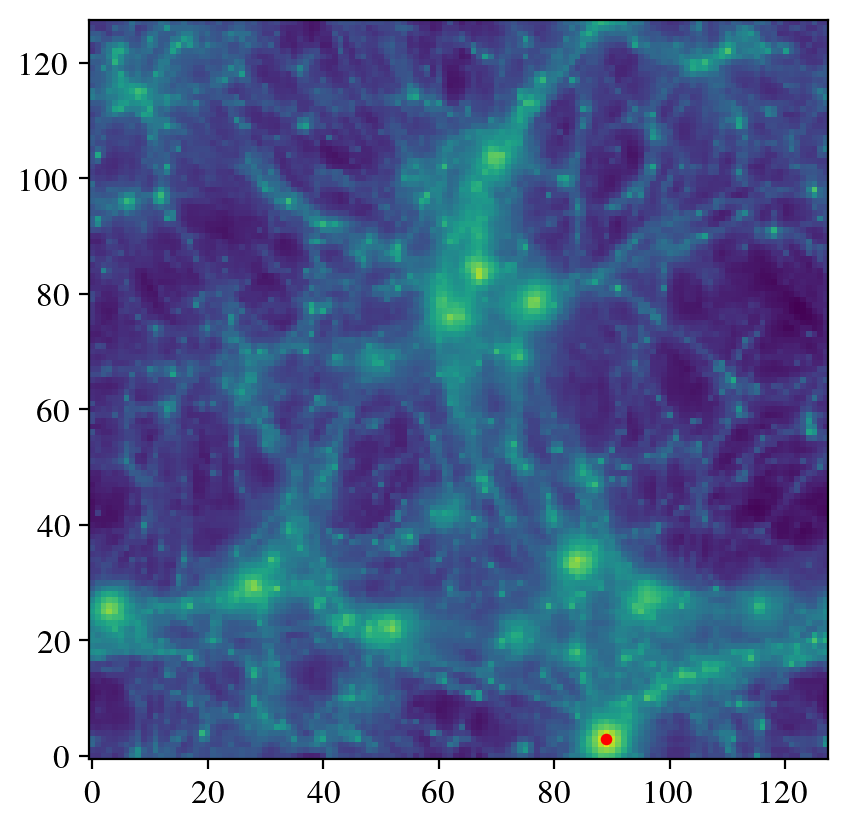

In [155]:
idx=0
plt.imshow(np.log10(np.mean(gas[0,:,:,:],axis=2)) )
#plt.scatter(xy.T[1][i],xy.T[0][i],marker='o',s=10,color='r')
#plt.scatter(3,26,marker='o',s=10,color='r')
#plt.scatter(26,3,marker='o',s=10,color='r')
#plt.scatter(89,26,marker='o',s=10,color='r')
#plt.scatter(26,89,marker='o',s=10,color='r')
#plt.scatter(67, 84,marker='o',s=10,color='r') # x y 
plt.scatter(xp[idx],yp[idx],marker='o',s=10,color='r')

#plt.scatter(3,26,marker='o',s=10,color='r')
plt.grid(False)

45


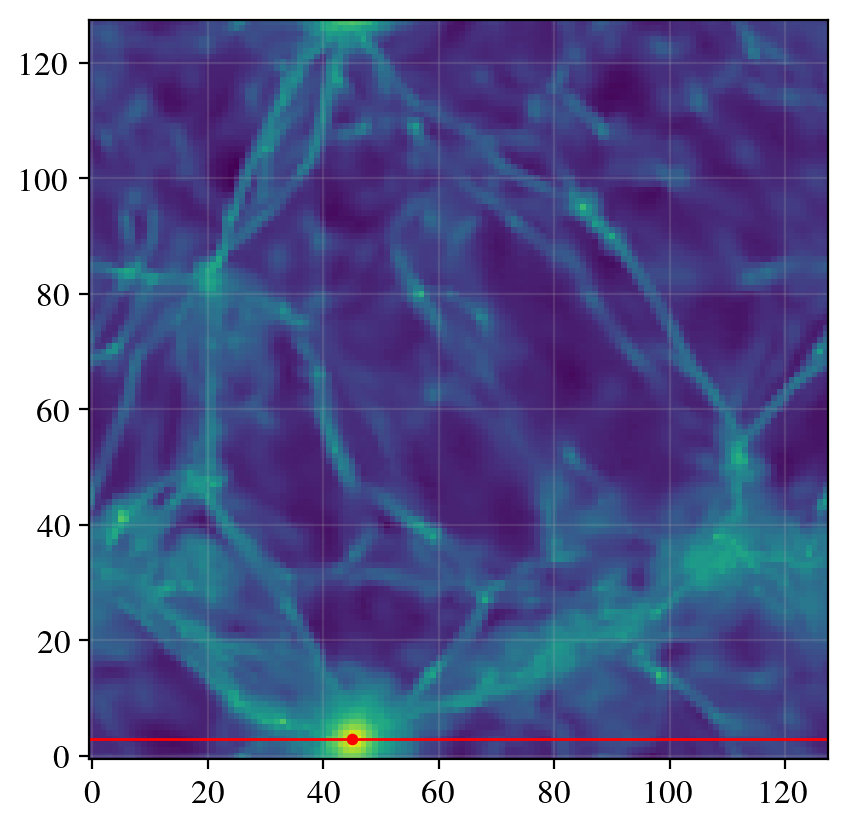

In [157]:
plt.imshow(np.log10(gas[0,:,int(xp[idx]),:]) ) #y,x
plt.axhline(y=yp[idx],color='r')

Q = np.argmax(np.log10(gas[0,int(yp[idx]),int(xp[idx]),:]) )
#plt.axvline(x=84,color='r')
print(Q)
#plt.scatter(14,84,marker='o',s=10,color='r')
plt.scatter(Q,yp[idx],marker='o',s=10,color='r')

In [162]:
mret

array([[11898.48828125,  3603.82920805],
       [ 6987.22851562,  1478.8038619 ],
       [ 8168.52636719,  1376.85045796],
       [ 5475.68896484,  1315.04138304],
       [ 3878.66796875,  1176.92822692],
       [ 3905.796875  ,  1049.01447476],
       [ 3119.58276367,  1090.52155997],
       [ 1115.62609863,   840.9391802 ],
       [ 3430.80786133,  1042.64262926],
       [ 4585.82421875,   669.28182415]])

In [ ]:
np.argmax(np.log10(gas[0,84,67,:]) )